In [1]:
import math
import lmfit
import json
import numpy as np
import pandas as pd
from scipy import optimize
from matplotlib import ticker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.optimize import leastsq

In [2]:
# 情绪与股市数据
raw_data = pd.read_csv('data/VIP_day.csv')
# 关键词数据，涨跌买卖
keyword_data = pd.read_csv('data/keyword_results.csv')
# 转发与总量
sum_retweet_data = pd.read_csv('data/sum_retweet_results.csv')
# 合并数据
data = pd.merge(pd.merge(raw_data, keyword_data), sum_retweet_data)

print('载入数据完成')
# print(data)
# print(sum(data.su_stat))
# print(sum(data.su))
# print(sum(data.bull), sum(data.bear))

载入数据完成


## 线性分析

- 1 相关性和 $R^{2}$
- 2 平衡点 blance point
- 3 斜率比值 $\lambda$
- 4 绝对值相同x值对应的两个y的比值 曲线

In [3]:
def union_data(x_data, y_data, posi):
    """
    间隔为0.2
    """
    interval = 0.2
    X = []
    Y = []
    if posi == 1:
        x_y = {round(i, 1): [] for i in np.arange(0, 6.4 + interval, interval)}
    elif posi == -1:
        x_y = {round(i, 1): [] for i in np.arange(-8.0, interval, interval)}
    
    for x, y in zip(x_data, y_data):
        k = round(int(x / interval) * interval, 1) # 取 interval
        try:
            x_y[k].append(y)
        except:
            pass
    
    for x in x_y:
        y_list = x_y[x]
        if y_list:
            y = np.array(y_list).mean()
        else:
            y = -1
#         x_y[x] = y
        X.append(x)
        Y.append(y)
    
    last = 10000
    for i in range(len(Y)): 
        if Y[i] != -1:
            last = Y[i]
        if Y[i] == -1: # 找到第一个0
            for j in range(i+1, len(Y)): 
                if Y[j] != -1: # 找到最近的一个非0
                    now = Y[j]
                    break
            else:
                for m in range(i, len(Y)):
                    Y[m] = last
                return X, Y

            gap = (now - last) / (j - i + 1)
            for k in range(i, j):
                Y[k] = last + gap * (k - i + 1)
    return X, Y


def my_line(x_n, y_n, x, y, **kw):
    '''
    牛熊市下用户行为的差异
    :param x_n: 收益率小于0
    :param y_n:
    :param x: 收益率大于0
    :param y:
    :return:
    '''

    def linear(input_x, input_y):
        '''
        线性回归
        :param x:
        :param y:
        :return: 拟合参数
        '''
        clf = LinearRegression()
        X = [[i] for i in input_x.tolist()]
        y = input_y.tolist()
        clf.fit(X, y)
        return clf.coef_[0], clf.intercept_, clf.score(X, y)
    
    def liner_model(k, b):
        def model(x):
            return b + k * x
        return model
    
    
    res = {}
    plt.figure(figsize=(12, 5))
    
    plt.scatter(x_n, y_n, alpha=0.3, label='$r < 0$')
    plt.scatter(x, y, alpha=0.3, label='$r > 0$')
    
    union_x_n, union_y_n = union_data(x_n, y_n, posi=-1)
    union_x, union_y = union_data(x, y, posi=1)
    plt.plot(union_x_n, union_y_n, c='grey')
    plt.plot(union_x, union_y, c='grey')
    
    
    # 正
    print('return > 0')
    
    # 画拟合直线
    print('---------- 收益率 < 0 ----------')
    a_n, b_n, r2 = linear(x_n, y_n)
    print('相关性：', x_n.corr(y_n))
    print('参数：', a_n, b_n)
    res['k_n'] = a_n
    res['b_n'] = b_n
    print('R^2：', r2)
    mod_n = liner_model(a_n, b_n)
    p_0 = mod_n(0)
    p_8 = mod_n(-8)
    p_4 = mod_n(4)
    plt.plot([-8, 0], [p_8, p_0], '-', c='purple', linewidth=2)
    plt.plot([0, 4], [p_0, p_4], 'r--', linewidth=2)
    
    pars = lmfit.Parameters()
    pars.add_many(('k', 1000), ('b', 1000))
    def residual(p):
        return p['k'] * x_n + p['b'] - y_n

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))

    print('---------- 收益率 > 0 ----------')
    a, b, r2 = linear(x, y)
    print('相关性：', x.corr(y))
    print('参数：', a, b)
    res['k'] = a
    res['b'] = b
    print('R^2：', r2)
    mod = liner_model(a, b)
    p_0 = mod(0)
    p_8 = mod(8)
    plt.plot([0, 8], [p_0, p_8], 'r-', linewidth=1.8)
    
    pars = lmfit.Parameters()
    pars.add_many(('k', -1000), ('b', 1000))
    def residual(p):
        return p['k'] * x + p['b'] - y

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    
    
    print('- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -')
    print('斜率比例：', a_n / a)
    the_point = (b - b_n) / (a_n - a)
    print('平衡点：', the_point)
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    plt.scatter(the_point, mod(the_point), c='k', linewidths=3, zorder=100, label='balance point')
    
    
    plt.xlim(-9, 9)
    plt.xlabel('$return$', fontsize=15)
    if 'ylabel' in kw:
        plt.ylabel(kw['ylabel'], fontsize=15)
    else:
        plt.ylabel('amount of tweets', fontsize=15)
    plt.legend(loc=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
#     plt.grid()
    if 'out' in kw:
        plt.savefig(kw['out'], dpi=300)
    plt.show()
    plt.close('all')
    
    
    # -----------------------------------------------------
    
    print('收益率为0：', mod_n(0) / mod(0))
    print('收益率为1：', mod_n(-1) / mod(1))
    print('收益率为2：', mod_n(-2) / mod(2))
    print('收益率为4：', mod_n(-4) / mod(4))
    print('收益率为6：', mod_n(-6) / mod(6))
    
    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    x = np.arange(0, 8, 0.1)
    y = [mod_n(-i) / mod(i) for i in x]
    res['y_ratio'] = y
    plt.plot(x, y)
    plt.show()
    plt.close('all')
    
    
    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)    
    len_union_x = len(union_x)
#     print(union_x_n, union_y_n)
#     print(union_x, union_y)
    union_y_n.reverse()
    union_ratio = [union_y_n[i] / union_y[i] for i in range(len_union_x)]
    res['union_y_ratio'] = union_ratio
    res['union_x'] = union_x
    plt.plot(union_x, union_ratio)
#     plt.legend(loc=1)
    plt.show()
    plt.close('all')
    
    res['union_y_n'] = union_y_n
    res['union_y'] = union_y 
    
    
    # 返回可以评估
    res['ratio'] = a_n / a
    res['point'] = the_point
    

    
    return res
    

    

## 非线性分析

- 1 斜率比值 $\lambda$
- 2 绝对值相同x值对应的两个y的比值

In [4]:
def my_nonlinear_model(p):
    def this_model(x):
        return p['A1'] * (x ** p['A2']) + p['b']
    return this_model


def my_nonline(x_n, y_n, x, y, **kw):
    """
    拟合损失厌恶曲线
    注意：需要初始化参数
    """
    plt.figure(figsize=(12, 5))
    plt.scatter(x_n, y_n, alpha=0.3, label='$r < 0$')
    plt.scatter(x, y, alpha=0.3, label='$r > 0$')
    
    union_x_n, union_y_n = union_data(x_n, y_n, posi=-1)
    union_x, union_y = union_data(x, y, posi=1)
    plt.plot(union_x_n, union_y_n, c='grey')
    plt.plot(union_x, union_y, c='grey')
    
    # 正
    print('return > 0')
    pars = lmfit.Parameters()
    pars.add_many(('A1', 1000), ('A2', 1), ('b', 4000))
    def residual(p):
        return p['A1'] * (x ** p['A2']) + p['b'] - y

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    # ci1 = lmfit.conf_interval(mini, result)
    # lmfit.printfuncs.report_ci(ci1)
    
    mod_1 = my_nonlinear_model(result.params)
    x_fit = np.arange(0, 6, 0.1)
    y_fit = [mod_1(x) for x in x_fit]
    plt.plot(x_fit, y_fit, 'r-', linewidth=2)

    print('- * - ' * 15)

    # 负
    print('return < 0')
    pars = lmfit.Parameters()
    pars.add_many(('A1', -kw['k_n']), ('A2', 1.5), ('b', kw['b_n']))
    x_n = [-x for x in x_n]
    def residual(p):
        return p['A1'] * (x_n ** p['A2']) + p['b'] - y_n

    mini = lmfit.Minimizer(residual, pars)
    result = mini.minimize()
    print(lmfit.fit_report(result.params))
    # ci2 = lmfit.conf_interval(mini, result)
    # lmfit.printfuncs.report_ci(ci2)

    mod_2 = my_nonlinear_model(result.params)
    x_fit = np.arange(0, 8, 0.1)
    y_fit = [mod_2(x) for x in x_fit]
    x_fit = [-x for x in x_fit]
    plt.plot(x_fit, y_fit, '-', c='purple', linewidth=2)
    
    
    # 画图配置及输出
    plt.xlim(-9, 9)
    plt.xlabel('$return$', fontsize=15)
    if 'ylabel' in kw:
        plt.ylabel(kw['ylabel'], fontsize=15)
    else:
        plt.ylabel('amount of tweets', fontsize=15)
    plt.legend(loc=1)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=12)
#     plt.grid()
    if 'out' in kw:
        plt.savefig(kw['out'], dpi=300)
    plt.show()
    plt.close('all')
    
    # 比值
    print('收益率为0.5：', mod_2(0.5) / mod_1(0.5))
    print('收益率为1：', mod_2(1) / mod_1(1))
    print('收益率为2：', mod_2(2) / mod_1(2))
    print('收益率为4：', mod_2(4) / mod_1(4))
    print('收益率为6：', mod_2(6) / mod_1(6))
    

    plt.figure(figsize=(6, 4))
    plt.xlabel('$r$', fontsize=15)
#     plt.xlim(0, 10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    x = np.arange(0, 8, 0.1)
    y = [mod_2(i) / mod_1(i) for i in x]
    kw['non_y_ratio'] = y
    plt.plot(np.arange(0, 10, 1), [1] * 10)
    plt.plot(x, y)
    plt.plot(kw['union_x'], kw['union_y_ratio'])
#     plt.legend(loc=1)
    plt.plot(np.arange(0, 10, 1), [1] * 10, alpha=0.1, linewidth=4)
    plt.show()
    plt.close('all')
    
    return kw



In [5]:
# 合并线性和非线性分析

def my_analysis(x_n, y_n, x, y, **kw):
    res = my_line(x_n, y_n, x, y, **kw)
    res = dict(kw, **res)
    res = my_nonline(x_n, y_n, x, y, **res)
    return res

收益率与总量
return > 0
---------- 收益率 < 0 ----------
相关性： -0.5052169126948854
参数： -3966.963034124943 32555.48029332434
R^2： 0.25524412887295134
[[Variables]]
    k: -3966.96303 +/- 562.734105 (14.19%) (init = 1000)
    b:  32555.4808 +/- 1585.55341 (4.87%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.23408099509994626
参数： 2144.4498366319945 29656.868140928946
R^2： 0.05479391226698105
[[Variables]]
    k:  2144.44984 +/- 636.187243 (29.67%) (init = -1000)
    b:  29656.8686 +/- 1283.52803 (4.33%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.8498744835903136
平衡点： 0.4742949320713106


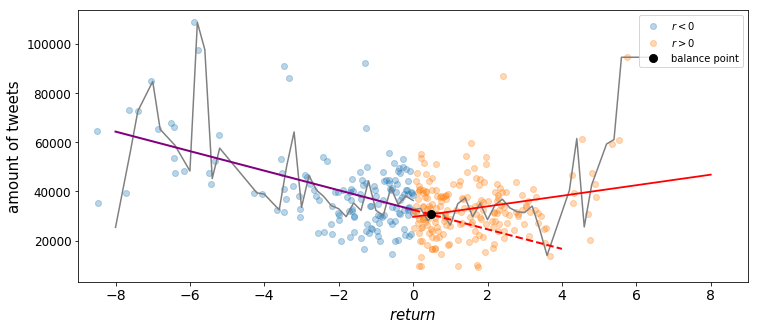

收益率为0： 1.0977383093393827
收益率为1： 1.1484569083966765
收益率为2： 1.1927674337254306
收益率为4： 1.2664771426535784
收益率为6： 1.3253182237761862


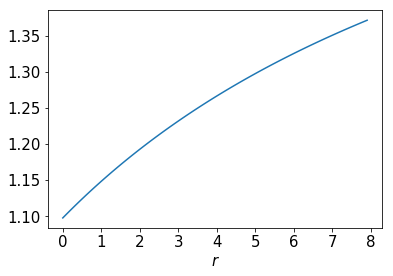

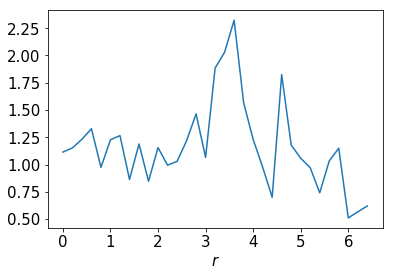

return > 0
[[Variables]]
    A1:  6.9612e-05 +/- 3.7936e-04 (544.96%) (init = 1000)
    A2:  11.7405120 +/- 3.15269091 (26.85%) (init = 1)
    b:   32151.6234 +/- 773.148685 (2.40%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.189
    C(A2, b)  =  0.185
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  1812.65897 +/- 1558.12836 (85.96%) (init = 3966.963)
    A2:  1.39796694 +/- 0.42394128 (30.33%) (init = 1.5)
    b:   34492.6757 +/- 2106.92926 (6.11%) (init = 32555.48)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.987
    C(A1, b)  = -0.802
    C(A2, b)  =  0.749


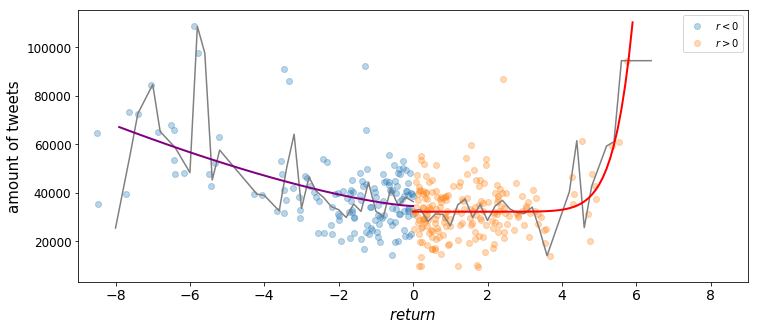

收益率为0.5： 1.0942064471142967
收益率为1： 1.1291913354664993
收益率为2： 1.221377954894791
收益率为4： 1.4281470451811955
收益率为6： 0.44512861941134213


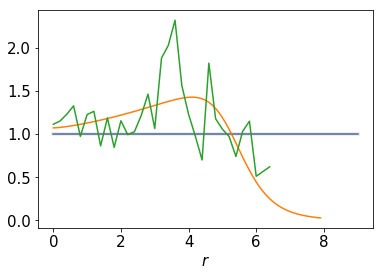

In [6]:
# 收益率与总量
# 散点图及线性拟合
print("收益率与总量")
x_n = data.close[data.close<0]
y_n = data.su[data.close<0]
x = data.close[data.close>0]
y = data.su[data.close>0]

# scatter_and_line(x_n, y_n, x, y, ylabel='$value(r)$', out='figure/value_r.pdf')
# scatter_and_line(x_n, y_n, x, y)
# non_line(x_n, y_n, x, y)
my_analysis(x_n, y_n, x, y, hi='Kay')

pass

## 不同收益率下的情况

x_n = data.close[data.close<-0.1]
y_n = data.su[data.close<-0.1]
x = data.close[data.close>0.1]
y = data.su[data.close>0.1]
scatter_and_line(x_n, y_n, x, y)

x_n = data.close[data.close<-0.5]
y_n = data.su[data.close<-0.5]
x = data.close[data.close>0.5]
y = data.su[data.close>0.5]
scatter_and_line(x_n, y_n, x, y)

x_n = data.close[data.close<-1]
y_n = data.su[data.close<-1]
x = data.close[data.close>1]
y = data.su[data.close>1]
scatter_and_line(x_n, y_n, x, y)

x_n = data.close[data.close<-2]
y_n = data.su[data.close<-2]
x = data.close[data.close>2]
y = data.su[data.close>2]
scatter_and_line(x_n, y_n, x, y)

愤怒
return > 0
---------- 收益率 < 0 ----------
相关性： -0.4986818175060812
参数： -686.0055265490279 3520.252934252808
R^2： 0.2486835551111689
[[Variables]]
    k: -686.005527 +/- 99.0219625 (14.43%) (init = 1000)
    b:  3520.25299 +/- 279.003186 (7.93%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.22553653782899047
参数： 354.7723214607363 3368.480281109692
R^2： 0.0508667298958877
[[Variables]]
    k:  354.772321 +/- 109.463262 (30.85%) (init = -1000)
    b:  3368.48033 +/- 220.845618 (6.56%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.933650076546206
平衡点： 0.145826175521841


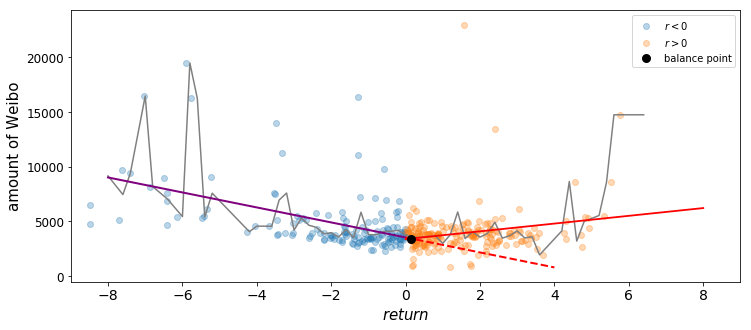

收益率为0： 1.045056714149182
收益率为1： 1.1297268570759755
收益率为2： 1.199665053178443
收益率为4： 1.3084457474392854
收益率为6： 1.389144522380563


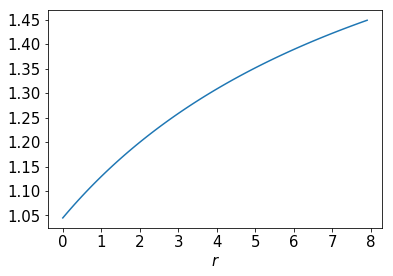

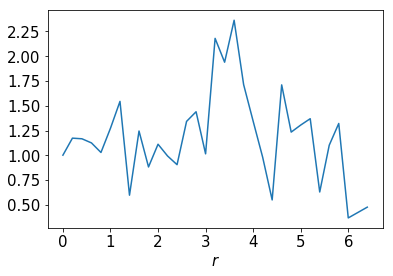

return > 0
[[Variables]]
    A1:  3.3602e-11 +/- 3.9157e-10 (1165.30%) (init = 354.7723)
    A2:  19.0737322 +/- 6.45486568 (33.84%) (init = 0.88)
    b:   3818.73011 +/- 132.981001 (3.48%) (init = 3368.48)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.141
    C(A2, b)  =  0.140
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  491.928376 +/- 378.457687 (76.93%) (init = 686.0055)
    A2:  1.16554557 +/- 0.37625540 (32.28%) (init = 1.5)
    b:   3692.73876 +/- 433.011662 (11.73%) (init = 3520.253)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.982
    C(A1, b)  = -0.855
    C(A2, b)  =  0.795


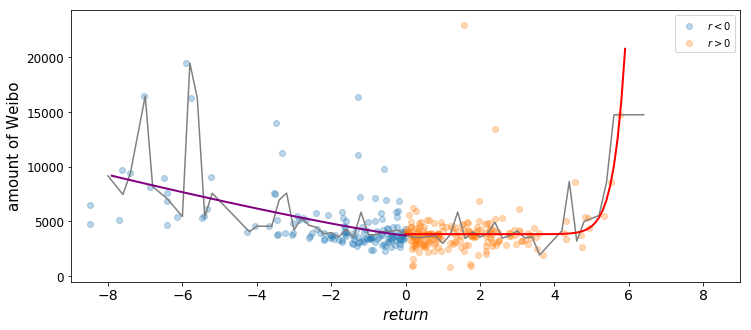

收益率为0.5： 1.0244343469413604
收益率为1： 1.0958268883111382
收益率为2： 1.255973222730896
收益率为4： 1.6108946541527165
收益率为6： 0.28188473360270166


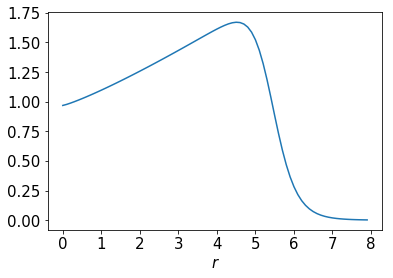

厌恶
return > 0
---------- 收益率 < 0 ----------
相关性： -0.41659094298348553
参数： -337.45746618642875 4327.95699834185
R^2： 0.17354801377586948
[[Variables]]
    k: -337.457466 +/- 61.1552904 (18.12%) (init = 1000)
    b:  4327.95706 +/- 172.310471 (3.98%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.2527593096047844
参数： 280.4844476029984 4182.642087783065
R^2： 0.06388726859188731
[[Variables]]
    k:  280.484448 +/- 76.6898103 (27.34%) (init = -1000)
    b:  4182.64215 +/- 154.724137 (3.70%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.2031236279598316
平衡点： 0.23515949851607362


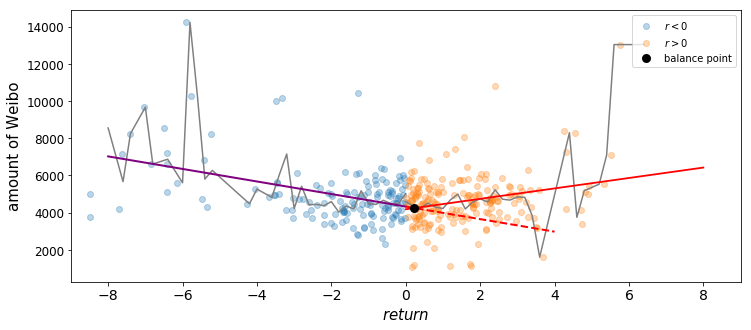

收益率为0： 1.0347423727655851
收益率为1： 1.045324264848502
收益率为2： 1.0546547658851821
收益率为4： 1.0703556159888563
收益率为6： 1.0830532727420998


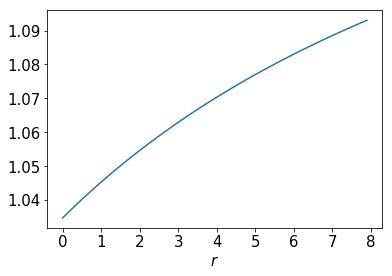

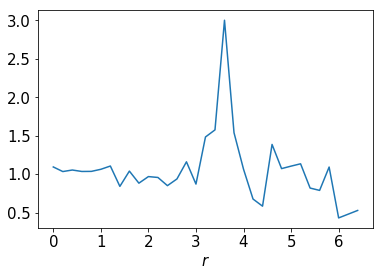

return > 0
[[Variables]]
    A1:  8.5777e-18 +/- 1.4892e-16 (1736.08%) (init = 280.4844)
    A2:  27.6062745 +/- 9.75620276 (35.34%) (init = 0.88)
    b:   4556.23462 +/- 92.2124748 (2.02%) (init = 4182.642)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.104
    C(A2, b)  =  0.103
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  188.699885 +/- 195.713478 (103.72%) (init = 337.4575)
    A2:  1.29457218 +/- 0.50977443 (39.38%) (init = 1.5)
    b:   4459.80791 +/- 244.365865 (5.48%) (init = 4327.957)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.985
    C(A1, b)  = -0.826
    C(A2, b)  =  0.770


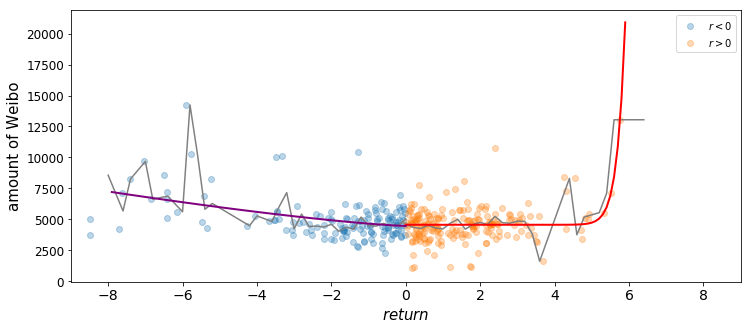

收益率为0.5： 0.9957197388345369
收益率为1： 1.0202520683103296
收益率为2： 1.0804309129575356
收益率为4： 1.2279556591125687
收益率为6： 0.20866210470254623


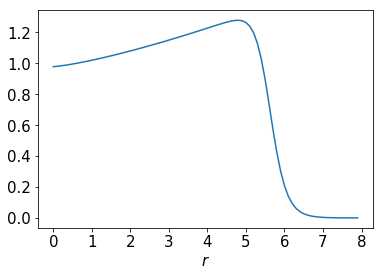

高兴
return > 0
---------- 收益率 < 0 ----------
相关性： -0.1729850785765219
参数： -321.2216282585059 11152.695371385456
R^2： 0.029923837410125387
[[Variables]]
    k: -321.221628 +/- 151.885058 (47.28%) (init = 1000)
    b:  11152.6955 +/- 427.949663 (3.84%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.11066072930882129
参数： 317.3818102732233 10108.253485234356
R^2： 0.012245797011160242
[[Variables]]
    k:  317.381810 +/- 203.603346 (64.15%) (init = -1000)
    b:  10108.2536 +/- 410.776236 (4.06%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.012098418563991
平衡点： 1.6355093366745266


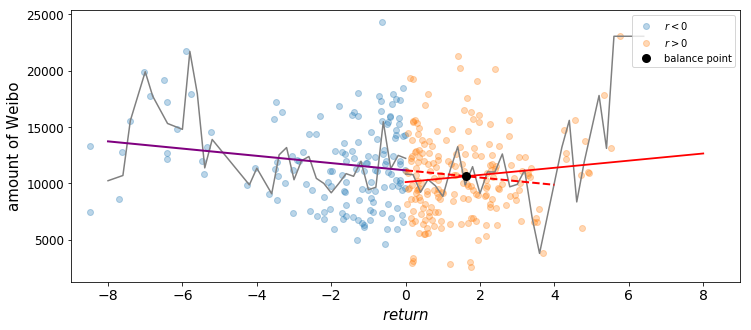

收益率为0： 1.1033256524162922
收益率为1： 1.1005484725317496
收益率为2： 1.0979353855403917
收益率为4： 1.0931465620215317
收益率为6： 1.0888638379379312


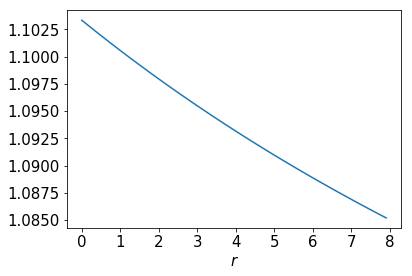

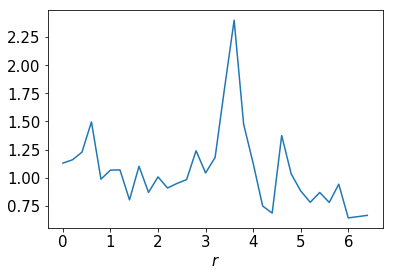

return > 0
[[Variables]]
    A1:  2.3138e-07 +/- 2.9508e-06 (1275.32%) (init = 317.3818)
    A2:  14.0666670 +/- 7.28255176 (51.77%) (init = 0.88)
    b:   10462.3267 +/- 259.965394 (2.48%) (init = 10108.25)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.172
    C(A2, b)  =  0.170
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  59.4237060 +/- 199.753961 (336.15%) (init = 321.2216)
    A2:  1.92550805 +/- 1.66243356 (86.34%) (init = 1.5)
    b:   11365.6461 +/- 454.530325 (4.00%) (init = 11152.7)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.993
    C(A1, b)  = -0.681
    C(A2, b)  =  0.641


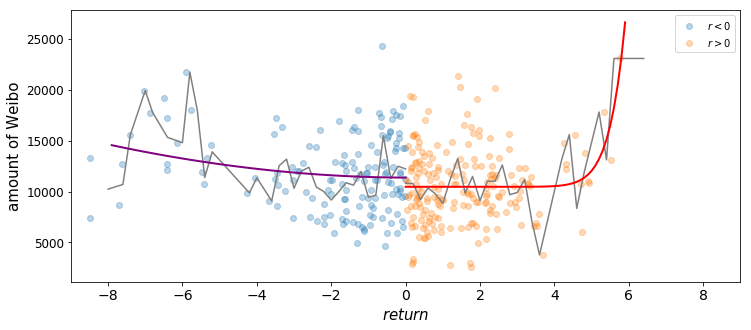

收益率为0.5： 1.0878353902338662
收益率为1： 1.0920199815234344
收益率为2： 1.1079155931226363
收益率为4： 1.1607423184551173
收益率为6： 0.4284747316791637


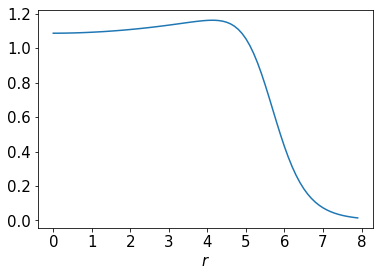

低落
return > 0
---------- 收益率 < 0 ----------
相关性： -0.6245765838357831
参数： -718.8489187944205 1016.2692058526395
R^2： 0.3900959090759769
[[Variables]]
    k: -718.848919 +/- 74.6446520 (10.38%) (init = 1000)
    b:  1016.26922 +/- 210.317946 (20.70%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.37805027524414986
参数： 320.43497663174827 1132.4757407060945
R^2： 0.14292201061217746
[[Variables]]
    k:  320.434977 +/- 56.0495963 (17.49%) (init = -1000)
    b:  1132.47576 +/- 113.081848 (9.99%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -2.2433534764232035
平衡点： -0.11181404365532222


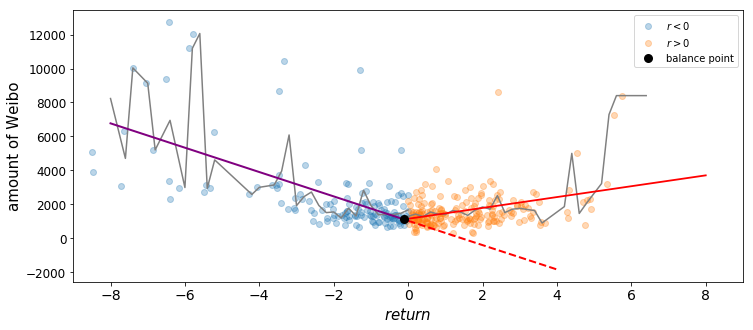

收益率为0： 0.8973871751274772
收益率为1： 1.194235890713439
收益率为2： 1.383806356417927
收益率为4： 1.6119789818654047
收益率为6： 1.7444233699222402


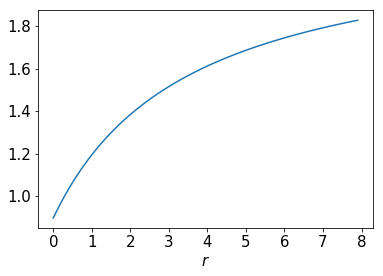

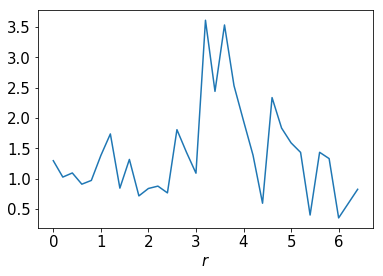

return > 0
[[Variables]]
    A1:  1.3317e-06 +/- 5.7060e-06 (428.48%) (init = 320.435)
    A2:  12.8025330 +/- 2.47734151 (19.35%) (init = 0.88)
    b:   1535.71527 +/- 64.8817224 (4.22%) (init = 1132.476)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.181
    C(A2, b)  =  0.178
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  441.196845 +/- 254.969250 (57.79%) (init = 718.8489)
    A2:  1.24461236 +/- 0.28419826 (22.83%) (init = 1.5)
    b:   1264.40213 +/- 307.505381 (24.32%) (init = 1016.269)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.984
    C(A1, b)  = -0.837
    C(A2, b)  =  0.780


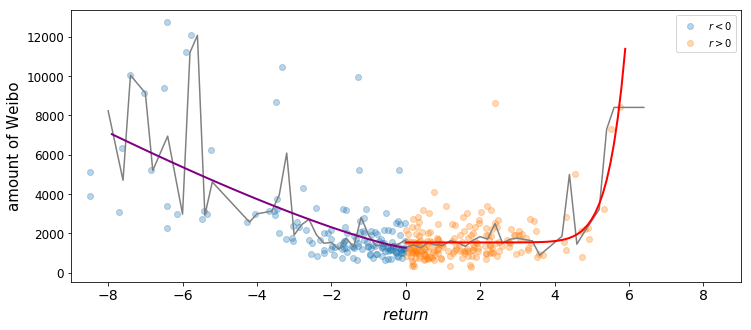

收益率为0.5： 0.9445739183653004
收益率为1： 1.1106218785910273
收益率为2： 1.5040713055269452
收益率为4： 2.333143245524093
收益率为6： 0.3905070719658648


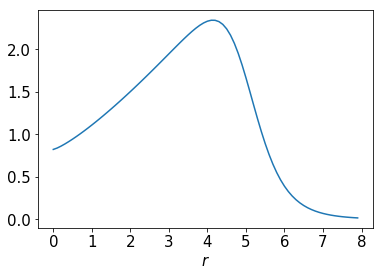

恐惧
return > 0
---------- 收益率 < 0 ----------
相关性： -0.4453438118513861
参数： -1426.7639211094775 11673.414969664364
R^2： 0.19833111075432253
[[Variables]]
    k: -1426.76392 +/- 238.215607 (16.70%) (init = 1000)
    b:  11673.4151 +/- 671.193663 (5.75%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.13740566972453067
参数： 553.3396889344012 10174.455079661966
R^2： 0.018880318072447055
[[Variables]]
    k:  553.339689 +/- 284.918156 (51.49%) (init = -1000)
    b:  10174.4552 +/- 574.831462 (5.65%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -2.5784593978015216
平衡点： 0.757010836402233


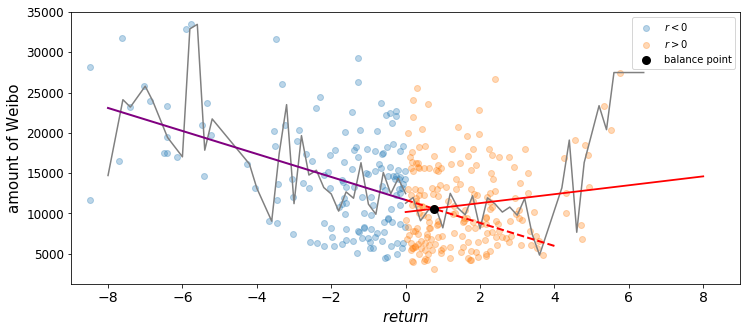

收益率为0： 1.1473258153155264
收益率为1： 1.2211436901386472
收益率为2： 1.2877200308685086
收益率为4： 1.4030296939428994
收益率为6： 1.499426334619686


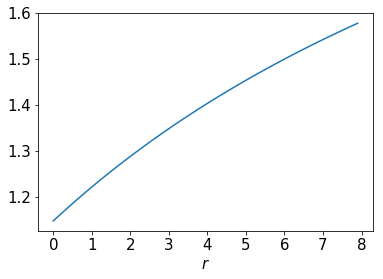

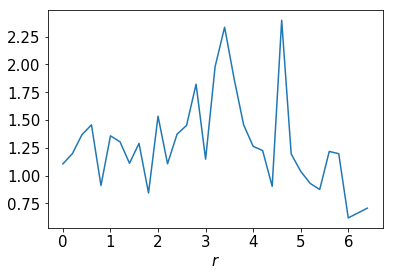

return > 0
[[Variables]]
    A1:  0.00250240 +/- 0.01447799 (578.56%) (init = 553.3397)
    A2:  8.98611058 +/- 3.40490389 (37.89%) (init = 0.88)
    b:   10719.0541 +/- 364.465730 (3.40%) (init = 10174.46)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.999
    C(A1, b)  = -0.223
    C(A2, b)  =  0.216
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  626.408450 +/- 642.813778 (102.62%) (init = 1426.764)
    A2:  1.41789822 +/- 0.50656207 (35.73%) (init = 1.5)
    b:   12396.8367 +/- 883.628417 (7.13%) (init = 11673.41)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.987
    C(A1, b)  = -0.798
    C(A2, b)  =  0.745


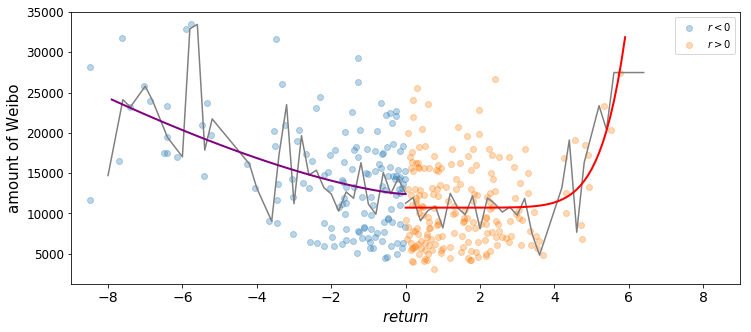

收益率为0.5： 1.1783945039631618
收益率为1： 1.2149618697954254
收益率为2： 1.3125140561258895
收益率为4： 1.4846157739513655
收益率为6： 0.5760211661635504


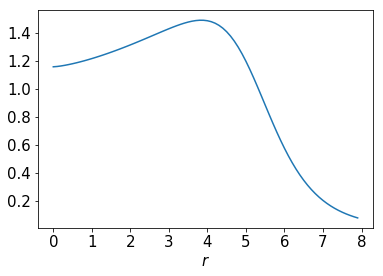

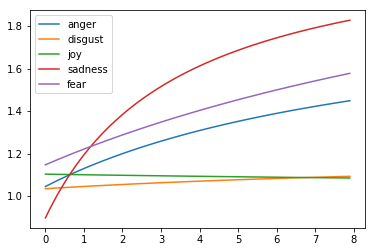

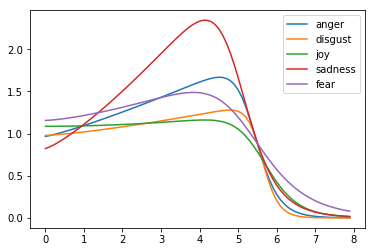

In [273]:
# 收益率与绝对情绪
# 散点图及线性拟合

print("愤怒")
x_n = data.close[data.close<0]
y_n = data.anger[data.close<0]
x = data.close[data.close>0]
y = data.anger[data.close>0]
r1 = my_analysis(x_n, y_n, x, y, hi='Kay')

print("厌恶")
x_n = data.close[data.close<0]
y_n = data.disgust[data.close<0]
x = data.close[data.close>0]
y = data.disgust[data.close>0]
r2 = my_analysis(x_n, y_n, x, y, hi='Kay')

print("高兴")
x_n = data.close[data.close<0]
y_n = data.joy[data.close<0]
x = data.close[data.close>0]
y = data.joy[data.close>0]
r3 = my_analysis(x_n, y_n, x, y, hi='Kay')

print("低落")
x_n = data.close[data.close<0]
y_n = data.sadness[data.close<0]
x = data.close[data.close>0]
y = data.sadness[data.close>0]
r4 = my_analysis(x_n, y_n, x, y, hi='Kay')

print("恐惧")
x_n = data.close[data.close<0]
y_n = data.fear[data.close<0]
x = data.close[data.close>0]
y = data.fear[data.close>0]
r5 = my_analysis(x_n, y_n, x, y, hi='Kay')

x = np.arange(0, 8, 0.1)
plt.plot(x, r1['y_ratio'], label='anger')
plt.plot(x, r2['y_ratio'], label='disgust')
plt.plot(x, r3['y_ratio'], label='joy')
plt.plot(x, r4['y_ratio'], label='sadness')
plt.plot(x, r5['y_ratio'], label='fear')
plt.legend()
plt.show()
plt.close()

x = np.arange(0, 8, 0.1)
plt.plot(x, r1['non_y_ratio'], label='anger')
plt.plot(x, r2['non_y_ratio'], label='disgust')
plt.plot(x, r3['non_y_ratio'], label='joy')
plt.plot(x, r4['non_y_ratio'], label='sadness')
plt.plot(x, r5['non_y_ratio'], label='fear')
plt.legend()
plt.show()
plt.close()

美国twitter来做股民的反应；

股市相关的关键词；找出股票相关的数据；查找相关文献；

两个国家的比较；

图中添加y=1；

过度乐观是否存在模型？来解释x>4之后的曲线

求实际数据y值的比值；0.5为区间，取大一些的范围；

随机取 （-1，1）范围的点，使得return对应的；

过度自信的语义的解释～

!! <font color=red>由于情绪的比值会使得问题更加复杂，先不考虑</font> 


# 收益率与相对情绪
# 相对情绪 log( 1+joy / 1+neg )

d_close = data.close
rela_anger = np.log((data.anger + 1) / (data.joy + 1))
rela_disgust = np.log((data.disgust + 1) / (data.joy + 1))
rela_sadness = np.log((data.sadness + 1) / (data.joy + 1))
rela_fear = np.log((data.fear + 1) / (data.joy + 1))

# 相对情绪的分布

fig = plt.figure(0)
rela_anger.hist(bins=30, alpha=0.8)
plt.show()
plt.close(0)

fig = plt.figure(0)
rela_disgust.hist(bins=30, alpha=0.8)
plt.show()
plt.close(0)

fig = plt.figure(0)
rela_sadness.hist(bins=30, alpha=0.8)
plt.show()
plt.close(0)

fig = plt.figure(0)
rela_fear.hist(bins=30, alpha=0.8)
plt.show()
plt.close(0)

print("愤怒")
x_n = data.close[data.close<0]
y_n = rela_anger[data.close<0]
x = data.close[data.close>0]
y = rela_anger[data.close>0]
scatter_and_line(x_n, y_n, x, y)

print("厌恶")
x_n = data.close[data.close<0]
y_n = rela_disgust[data.close<0]
x = data.close[data.close>0]
y = rela_disgust[data.close>0]
scatter_and_line(x_n, y_n, x, y)

print("低落")
x_n = data.close[data.close<0]
y_n = rela_sadness[data.close<0]
x = data.close[data.close>0]
y = rela_sadness[data.close>0]
scatter_and_line(x_n, y_n, x, y)

print("恐惧")
x_n = data.close[data.close<0]
y_n = rela_fear[data.close<0]
x = data.close[data.close>0]
y = rela_fear[data.close>0]
scatter_and_line(x_n, y_n, x, y)

涨
return > 0
---------- 收益率 < 0 ----------
相关性： -0.10373954778259559
参数： -185.7532133069348 9816.137197188455
R^2： 0.010761893774137497
[[Variables]]
    k: -185.753213 +/- 147.896670 (79.62%) (init = 1000)
    b:  9816.13734 +/- 416.712026 (4.25%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.4200377334842717
参数： 1498.7855244693906 9524.867182502318
R^2： 0.17643169755060414
[[Variables]]
    k:  1498.78552 +/- 231.298577 (15.43%) (init = -1000)
    b:  9524.86732 +/- 466.652249 (4.90%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -0.12393582021863757
平衡点： 0.17290787570170568


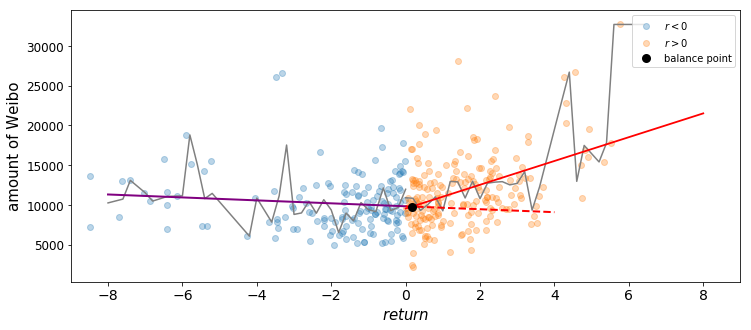

收益率为0： 1.0305799555106885
收益率为1： 0.9073118208967047
收益率为2： 0.8135511180421224
收益率为4： 0.6803571995130753
收益率为6： 0.5902853549242438


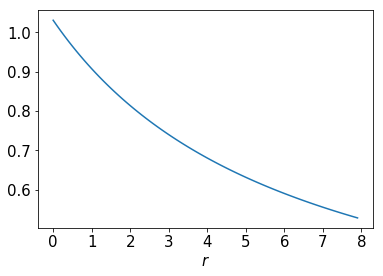

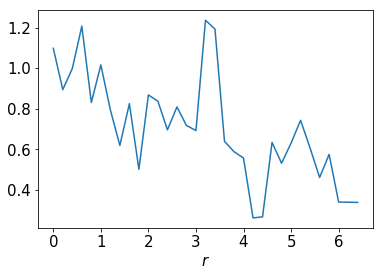

return > 0
[[Variables]]
    A1:  162.099730 +/- 153.910394 (94.95%) (init = 1498.786)
    A2:  2.48347629 +/- 0.59135367 (23.81%) (init = 0.88)
    b:   10704.4216 +/- 421.073485 (3.93%) (init = 9524.867)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.989
    C(A1, b)  = -0.663
    C(A2, b)  =  0.614
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  34.4202172 +/- 187.540976 (544.86%) (init = 185.7532)
    A2:  1.94863311 +/- 2.71400409 (139.28%) (init = 1.5)
    b:   9929.85370 +/- 440.233132 (4.43%) (init = 9816.137)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.993
    C(A1, b)  = -0.675
    C(A2, b)  =  0.636


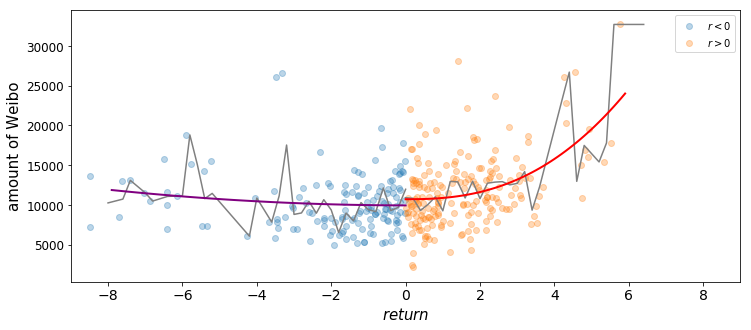

收益率为0.5： 0.9259660534922088
收益率为1： 0.9169699862030323
收益率为2： 0.8666573853817221
收益率为4： 0.6620153491201881
收益率为6： 0.4499303510541221


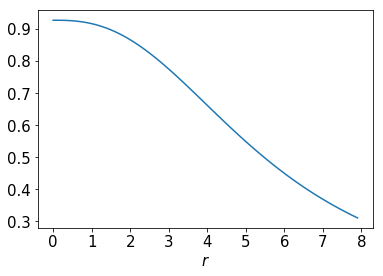

跌
return > 0
---------- 收益率 < 0 ----------
相关性： -0.7271208334529036
参数： -4488.55745123523 7781.169973341395
R^2： 0.528704706441245
[[Variables]]
    k: -4488.55745 +/- 351.935238 (7.84%) (init = 1000)
    b:  7781.17009 +/- 991.608832 (12.74%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.19979613088362752
参数： 874.6985915162995 6905.652745249879
R^2： 0.03991849391606761
[[Variables]]
    k:  874.698592 +/- 306.406072 (35.03%) (init = -1000)
    b:  6905.65285 +/- 618.184014 (8.95%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -5.1315475922446225
平衡点： 0.1632436007366798


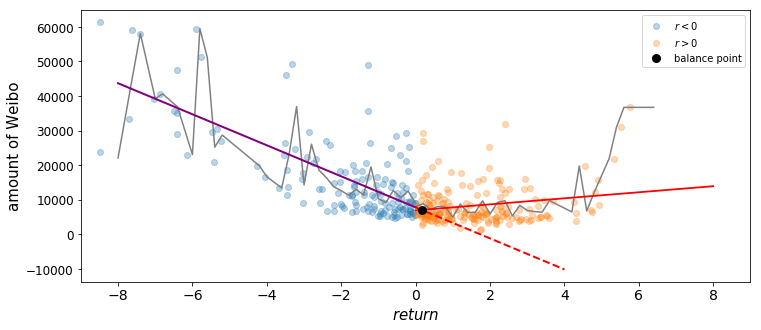

收益率为0： 1.1267826895428168
收益率为1： 1.5770145708710896
收益率为2： 1.9362435820329689
收益率为4： 2.4734999854335813
收益率为6： 2.856093417034834


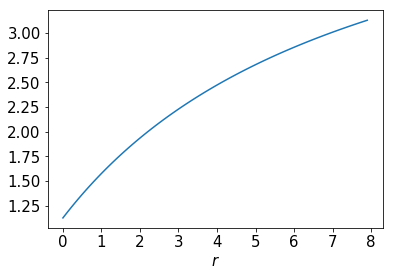

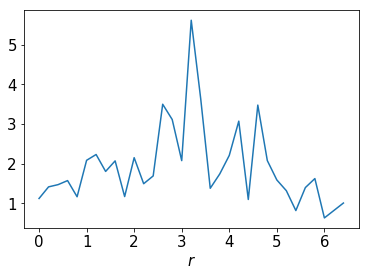

return > 0
[[Variables]]
    A1:  4.7749e-05 +/- 2.2536e-04 (471.98%) (init = 874.6986)
    A2:  11.5895492 +/- 2.72235201 (23.49%) (init = 0.88)
    b:   7817.28658 +/- 358.895214 (4.59%) (init = 6905.653)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.191
    C(A2, b)  =  0.186
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  2138.55735 +/- 1000.38385 (46.78%) (init = 4488.557)
    A2:  1.37331726 +/- 0.23111064 (16.83%) (init = 1.5)
    b:   9917.08295 +/- 1327.58838 (13.39%) (init = 7781.17)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.986
    C(A1, b)  = -0.808
    C(A2, b)  =  0.754


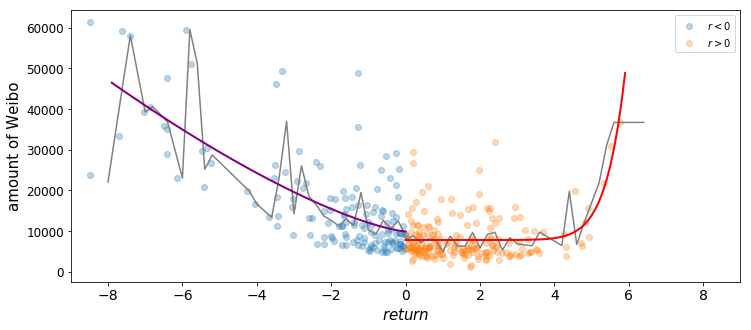

收益率为0.5： 1.3742072376481278
收益率为1： 1.5421770836204685
收益率为2： 1.977291925038006
收益率为4： 2.934428009985601
收益率为6： 0.6066558101122697


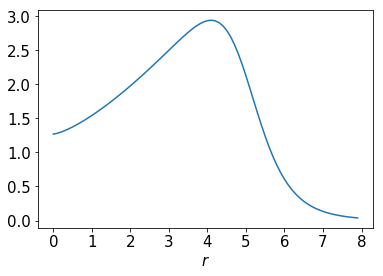

买
return > 0
---------- 收益率 < 0 ----------
相关性： -0.3115389409626029
参数： -327.94254094662864 5572.116062451489
R^2： 0.09705651173609997
[[Variables]]
    k: -327.942541 +/- 83.0676081 (25.33%) (init = 1000)
    b:  5572.11615 +/- 234.050371 (4.20%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.19830285615838814
参数： 305.2377308845147 5459.580822677781
R^2： 0.03932402276057445
[[Variables]]
    k:  305.237731 +/- 107.763000 (35.30%) (init = -1000)
    b:  5459.58090 +/- 217.415289 (3.98%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.0743840219107912
平衡点： 0.17773017382278583


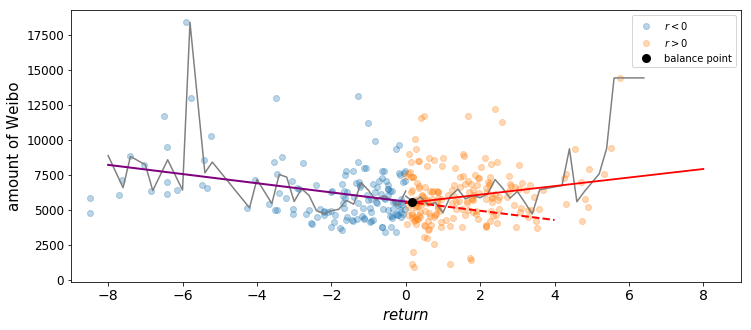

收益率为0： 1.020612432241366
收益率为1： 1.0234595501279484
收益率为2： 1.026020328724568
收益率为4： 1.0304398643322596
收益率为6： 1.0341193052002409


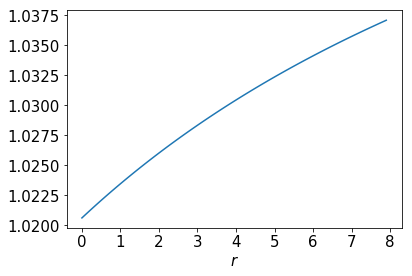

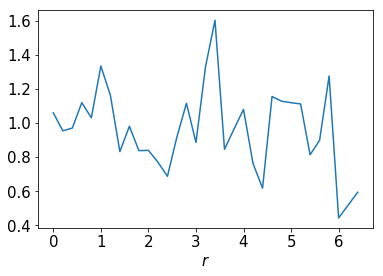

return > 0
[[Variables]]
    A1:  1.0873e-11 +/- 1.6758e-10 (1541.27%) (init = 305.2377)
    A2:  19.5795430 +/- 8.70882705 (44.48%) (init = 0.88)
    b:   5856.30943 +/- 135.144272 (2.31%) (init = 5459.581)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.138
    C(A2, b)  =  0.137
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  205.074063 +/- 287.602690 (140.24%) (init = 327.9425)
    A2:  1.23670834 +/- 0.69011629 (55.80%) (init = 1.5)
    b:   5680.72352 +/- 345.050657 (6.07%) (init = 5572.116)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.984
    C(A1, b)  = -0.839
    C(A2, b)  =  0.781


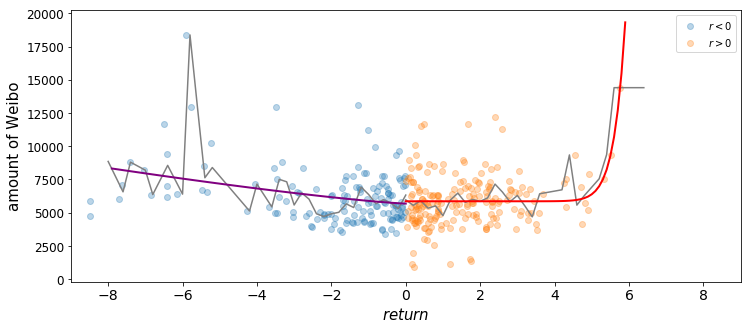

收益率为0.5： 0.9848770230330312
收益率为1： 1.0050352801345805
收益率为2： 1.052540274760009
收益率为4： 1.1631650540408327
收益率为6： 0.30772585273021197


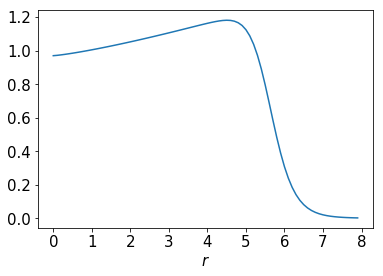

卖
return > 0
---------- 收益率 < 0 ----------
相关性： -0.22392041685998607
参数： -115.76751276547567 2577.8022556621145
R^2： 0.05014035308674991
[[Variables]]
    k: -115.767513 +/- 41.8445327 (36.15%) (init = 1000)
    b:  2577.80229 +/- 117.900693 (4.57%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.1417177823487376
参数： 130.55090548708847 2525.3844905559017
R^2： 0.020083929833844327
[[Variables]]
    k:  130.550905 +/- 65.1361290 (49.89%) (init = -1000)
    b:  2525.38453 +/- 131.414215 (5.20%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -0.8867614692793159
平衡点： 0.21280489489204935


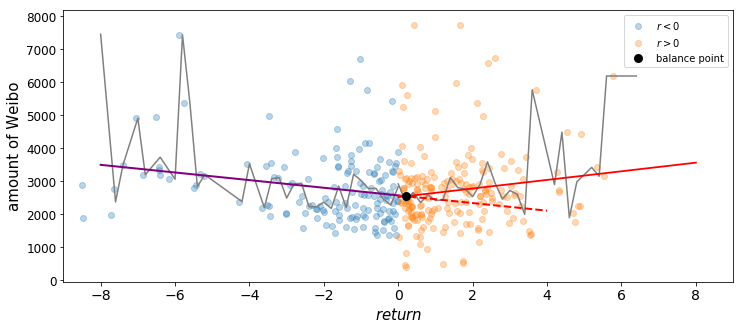

收益率为0： 1.0207563502913073
收益率为1： 1.0141699125817105
收益率为2： 1.0082006431003947
收益率为4： 0.9977963538600628
收益率为6： 0.9890341518659688


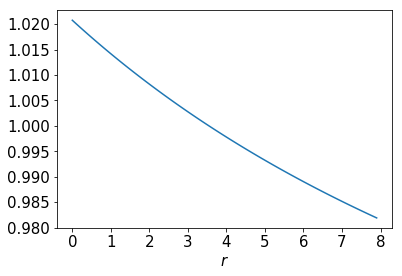

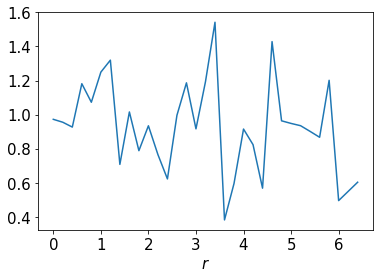

return > 0
[[Variables]]
    A1:  3.3864e-25 +/- 2.0581e-23 (6077.54%) (init = 130.5509)
    A2:  36.8325672 +/- 33.8600208 (91.93%) (init = 0.88)
    b:   2706.26605 +/- 83.2697655 (3.08%) (init = 2525.384)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  103.638164 +/- 188.489914 (181.87%) (init = 115.7675)
    A2:  1.05445935 +/- 0.87031922 (82.54%) (init = 1.5)
    b:   2588.51701 +/- 201.488483 (7.78%) (init = 2577.802)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.980
    C(A1, b)  = -0.880
    C(A2, b)  =  0.818


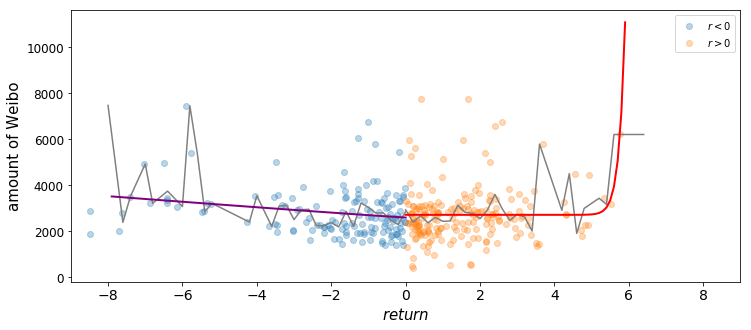

收益率为0.5： 0.9749287084707766
收益率为1： 0.9947858497546391
收益率为2： 1.0360279353358395
收益率为4： 1.1216831592011653
收益率为6： 0.17958296008484326


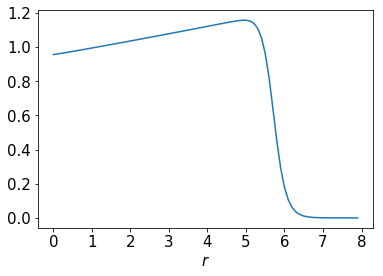

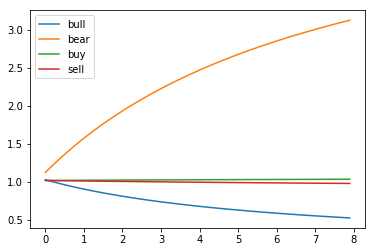

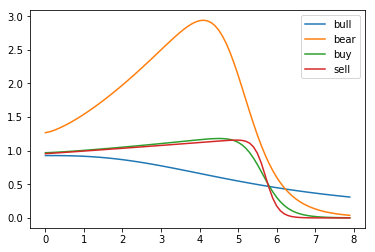

In [274]:
# 收益率与关键词词频
# 散点图及线性拟合

print("涨")
x_n = data.close[data.close<0]
y_n = data.bull[data.close<0]
x = data.close[data.close>0]
y = data.bull[data.close>0]
r1 = my_analysis(x_n, y_n, x, y, hi='Kay')

print("跌")
x_n = data.close[data.close<0]
y_n = data.bear[data.close<0]
x = data.close[data.close>0]
y = data.bear[data.close>0]
r2 = my_analysis(x_n, y_n, x, y, hi='Kay')

print("买")
x_n = data.close[data.close<0]
y_n = data.buy[data.close<0]
x = data.close[data.close>0]
y = data.buy[data.close>0]
r3 = my_analysis(x_n, y_n, x, y, hi='Kay')

print("卖")
x_n = data.close[data.close<0]
y_n = data.sell[data.close<0]
x = data.close[data.close>0]
y = data.sell[data.close>0]
r4 = my_analysis(x_n, y_n, x, y, hi='Kay')

x = np.arange(0, 8, 0.1)
plt.plot(x, r1['y_ratio'], label='bull')
plt.plot(x, r2['y_ratio'], label='bear')
plt.plot(x, r3['y_ratio'], label='buy')
plt.plot(x, r4['y_ratio'], label='sell')
plt.legend()
plt.show()
plt.close()

x = np.arange(0, 8, 0.1)
plt.plot(x, r1['non_y_ratio'], label='bull')
plt.plot(x, r2['non_y_ratio'], label='bear')
plt.plot(x, r3['non_y_ratio'], label='buy')
plt.plot(x, r4['non_y_ratio'], label='sell')
plt.legend()
plt.show()
plt.close()


转发数
return > 0
---------- 收益率 < 0 ----------
相关性： -0.481554584130837
参数： -1660.108707999601 5398.288122700377
R^2： 0.23189481749742313
[[Variables]]
    k: -1660.10871 +/- 250.909645 (15.11%) (init = 1000)
    b:  5398.28820 +/- 706.960235 (13.10%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.27449921992174886
参数： 1207.1652556148322 4610.153048914929
R^2： 0.07534982173764859
[[Variables]]
    k:  1207.16526 +/- 302.055193 (25.02%) (init = -1000)
    b:  4610.15312 +/- 609.405973 (13.22%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.375212465963557
平衡点： 0.2748726085427635


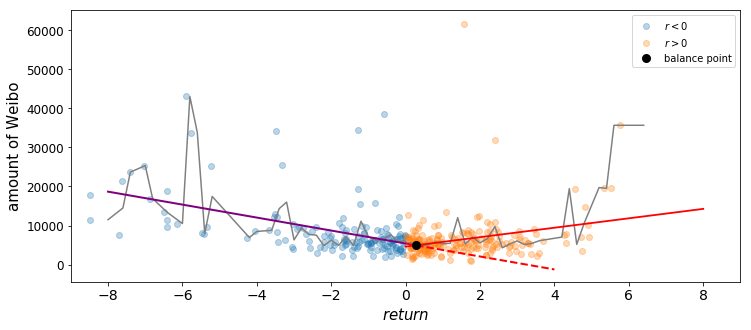

收益率为0： 1.170956379413683
收益率为1： 1.2133420351442397
收益率为2： 1.2411596474033337
收益率为4： 1.2754486806991405
收益率为6： 1.2957692588378011


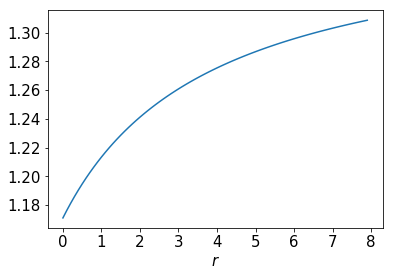

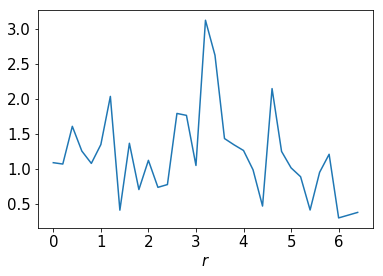

return > 0
[[Variables]]
    A1:  3.6241e-05 +/- 1.9869e-04 (548.25%) (init = 1207.165)
    A2:  11.6881127 +/- 3.17141123 (27.13%) (init = 0.88)
    b:   6087.31152 +/- 372.066034 (6.11%) (init = 4610.153)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.190
    C(A2, b)  =  0.186
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  1134.80886 +/- 928.603922 (81.83%) (init = 1660.109)
    A2:  1.18955682 +/- 0.40027543 (33.65%) (init = 1.5)
    b:   5866.67709 +/- 1078.42971 (18.38%) (init = 5398.288)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.983
    C(A1, b)  = -0.850
    C(A2, b)  =  0.791


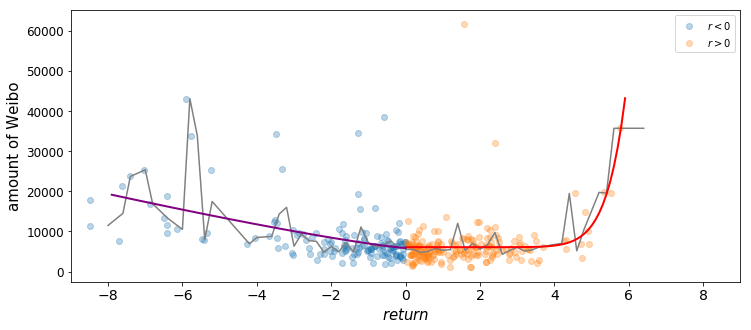

收益率为0.5： 1.0454894337394505
收益率为1： 1.1501770331060142
收益率为2： 1.3889240397220002
收益率为4： 1.8158482505161895
收益率为6： 0.3013418043231425


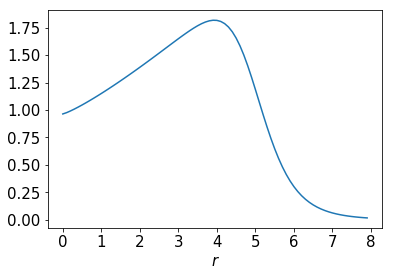

原创数
return > 0
---------- 收益率 < 0 ----------
相关性： -0.42137997748844563
参数： -2306.854326125342 27157.192170623963
R^2： 0.17756108542816296
[[Variables]]
    k: -2306.85433 +/- 412.300725 (17.87%) (init = 1000)
    b:  27157.1926 +/- 1161.69397 (4.28%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.13148314424425064
参数： 937.2845810171623 25046.715092014016
R^2： 0.01728781722035455
[[Variables]]
    k:  937.284581 +/- 504.761848 (53.85%) (init = -1000)
    b:  25046.7155 +/- 1018.37312 (4.07%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -2.461210152013695
平衡点： 0.6505507744947003


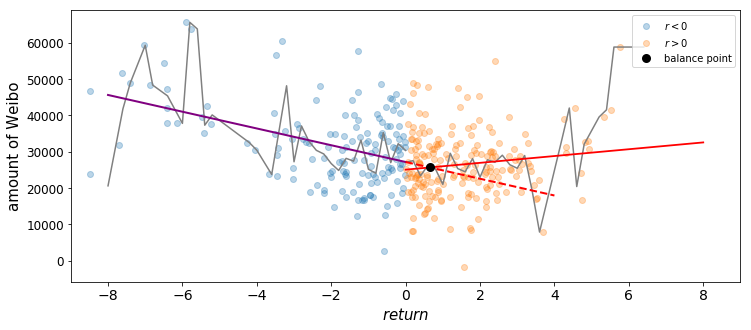

收益率为0： 1.0842616315495543
收益率为1： 1.1339303751350518
收益率为2： 1.1801406100489815
收益率为4： 1.2635364178789819
收益率为6： 1.336737960585775


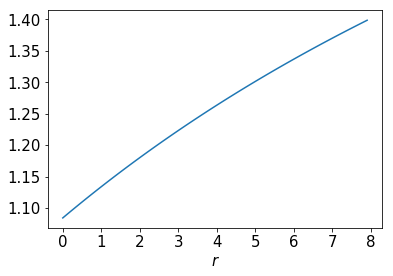

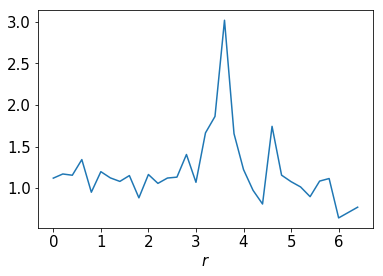

return > 0
[[Variables]]
    A1:  3.3571e-05 +/- 2.9231e-04 (870.72%) (init = 937.2846)
    A2:  11.7890509 +/- 5.02143486 (42.59%) (init = 0.88)
    b:   26064.3254 +/- 642.157875 (2.46%) (init = 25046.72)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.189
    C(A2, b)  =  0.185
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  862.397076 +/- 981.069370 (113.76%) (init = 2306.854)
    A2:  1.50561752 +/- 0.56456201 (37.50%) (init = 1.5)
    b:   28454.5857 +/- 1456.01309 (5.12%) (init = 27157.19)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.988
    C(A1, b)  = -0.777
    C(A2, b)  =  0.727


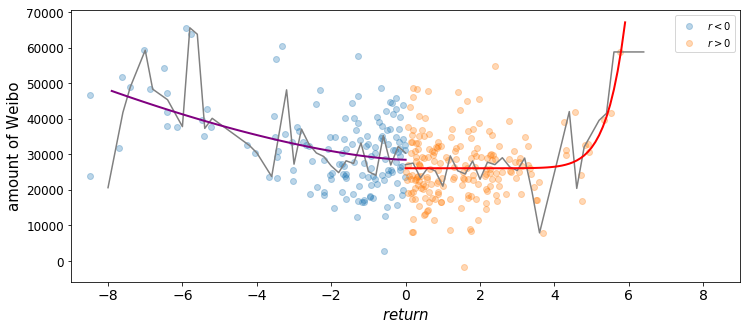

收益率为0.5： 1.1033588558331966
收益率为1： 1.1247934617189363
收益率为2： 1.185650808335908
收益率为4： 1.3369095416677892
收益率为6： 0.5418637443671469


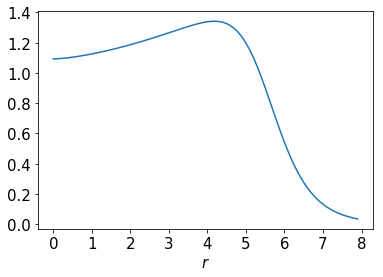

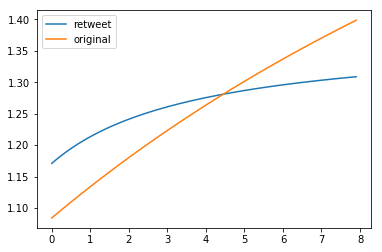

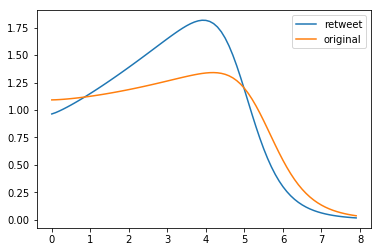

In [275]:
# 收益率与转发原创行为
# 散点图及线性拟合

print("转发数")
x_n = data.close[data.close<0]
y_n = data.retweet[data.close<0]
x = data.close[data.close>0]
y = data.retweet[data.close>0]
r1 = my_analysis(x_n, y_n, x, y, hi='Kay')

print("原创数")
x_n = data.close[data.close<0]
y_n = (data.su - data.retweet)[data.close<0]
x = data.close[data.close>0]
y = (data.su - data.retweet)[data.close>0]
r2 = my_analysis(x_n, y_n, x, y, hi='Kay')

x = np.arange(0, 8, 0.1)
plt.plot(x, r1['y_ratio'], label='retweet')
plt.plot(x, r2['y_ratio'], label='original')
plt.legend()
plt.show()
plt.close()

plt.plot(x, r1['non_y_ratio'], label='retweet')
plt.plot(x, r2['non_y_ratio'], label='original')
plt.legend()
plt.show()
plt.close()

In [276]:
# 抽取情绪数据

import pandas as pd

d = pd.read_csv('data/VIP_day.csv')

date = d['date']

e_sum = d['anger'] + d['disgust'] + d['joy'] + d['sadness'] + d['fear']

new_d = pd.DataFrame({
                        'date': date,
                        'anger': d['anger'] / e_sum,
                        'disgust': d['disgust'] / e_sum,
                        'joy': d['joy'] / e_sum,
                        'sadness': d['sadness'] / e_sum,
                        'fear': d['fear'] / e_sum,
                    })

new_d.to_csv('test.csv', index=None, float_format='%.4f', 
             columns=['date', 'anger', 'disgust', 'joy', 'sadness', 'fear'])


return > 0
---------- 收益率 < 0 ----------
相关性： -0.46564056352804795
参数： -1150.1243737550012 8981.840288461843
R^2： 0.21682113440271833
[[Variables]]
    k: -1150.12437 +/- 181.526686 (15.78%) (init = 1000)
    b:  8981.84042 +/- 511.467583 (5.69%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.22519617082312396
参数： 651.6887197164723 8057.199390433721
R^2： 0.05071331535339774
[[Variables]]
    k:  651.688720 +/- 201.395544 (30.90%) (init = -1000)
    b:  8057.19951 +/- 406.321928 (5.04%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.764837013375621
平衡点： 0.5131724824169507


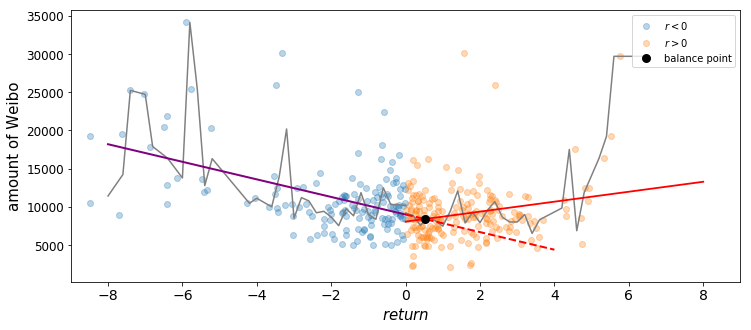

收益率为0： 1.1147595899297147
收益率为1： 1.1634050792784967
收益率为2： 1.2052771149716155
收益率为4： 1.2736680447499622
收益率为6： 1.3271618868391803


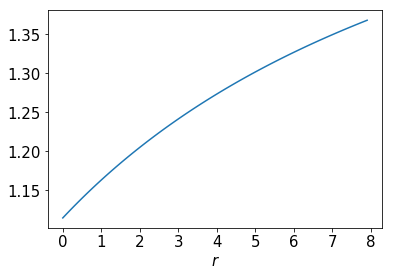

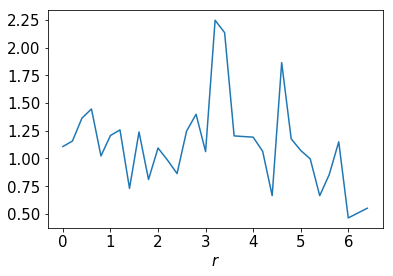

return > 0
[[Variables]]
    A1:  1.2684e-06 +/- 7.7838e-06 (613.65%) (init = 651.6887)
    A2:  13.4186193 +/- 3.53408070 (26.34%) (init = 0.88)
    b:   8814.62646 +/- 240.134996 (2.72%) (init = 8057.199)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.177
    C(A2, b)  =  0.174
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  395.923322 +/- 407.153625 (102.84%) (init = 1150.124)
    A2:  1.54703481 +/- 0.51051387 (33.00%) (init = 1.5)
    b:   9666.35168 +/- 627.149555 (6.49%) (init = 8981.84)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.989
    C(A1, b)  = -0.767
    C(A2, b)  =  0.719


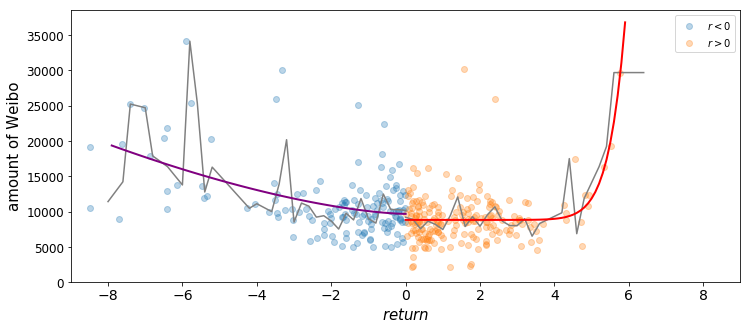

收益率为0.5： 1.1119973957651565
收益率为1： 1.141542985066013
收益率为2： 1.227877968558014
收益率为4： 1.4550651034855233
收益率为6： 0.36448851907523233


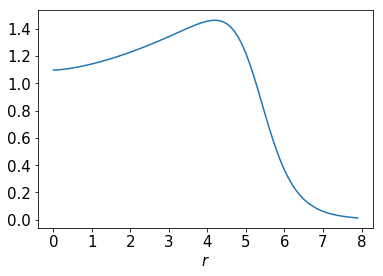

return > 0
---------- 收益率 < 0 ----------
相关性： -0.4859745225539644
参数： -2847.4526946171295 24815.546660055123
R^2： 0.2361712365715537
[[Variables]]
    k: -2847.45269 +/- 425.262431 (14.93%) (init = 1000)
    b:  24815.5470 +/- 1198.21473 (4.83%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.2737063205686867
参数： 1854.503096204062 22280.419998627076
R^2： 0.07491514991924864
[[Variables]]
    k:  1854.50310 +/- 465.484779 (25.10%) (init = -1000)
    b:  22280.4203 +/- 939.130382 (4.22%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.5354262284304148
平衡点： 0.5391642912459815


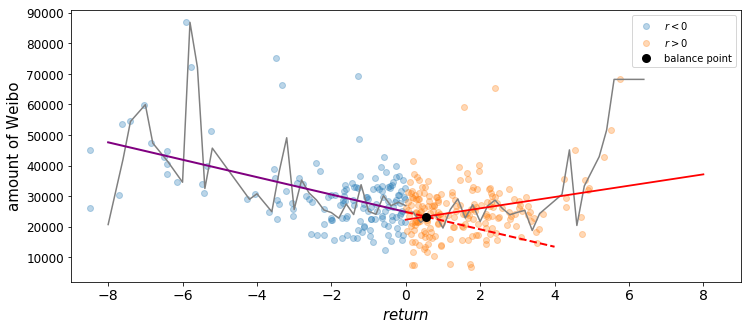

收益率为0： 1.1137827142210184
收益率为1： 1.1461813756761754
收益率为2： 1.1739563553663093
收益率为4： 1.2190999501612714
收益率为6： 1.2542195574983557


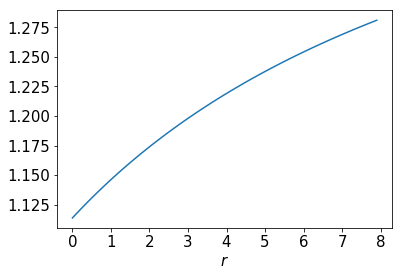

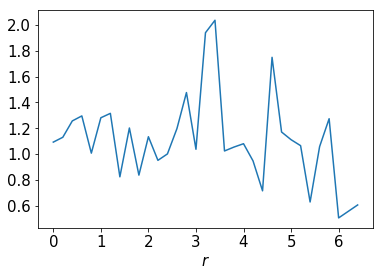

return > 0
[[Variables]]
    A1:  5.0137e-04 +/- 0.00230483 (459.71%) (init = 1854.503)
    A2:  10.4287243 +/- 2.67055631 (25.61%) (init = 0.88)
    b:   24483.7309 +/- 571.840650 (2.34%) (init = 22280.42)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.202
    C(A2, b)  =  0.197
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  1629.31045 +/- 1387.41392 (85.15%) (init = 2847.453)
    A2:  1.28100994 +/- 0.41782652 (32.62%) (init = 1.5)
    b:   25904.1094 +/- 1714.63402 (6.62%) (init = 24815.55)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.985
    C(A1, b)  = -0.829
    C(A2, b)  =  0.773


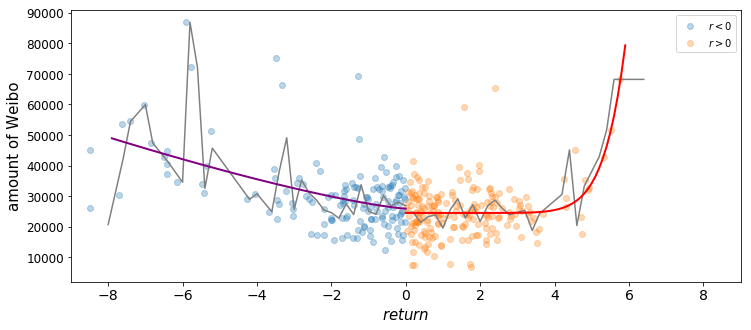

收益率为0.5： 1.085397592540578
收益率为1： 1.124559788960485
收益率为2： 1.219693116801938
收益率为4： 1.3966581127850655
收益率为6： 0.46837591677128054


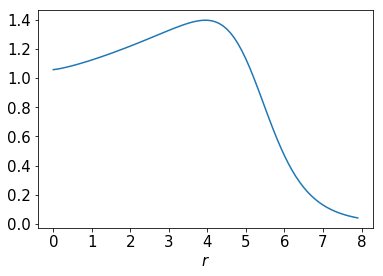

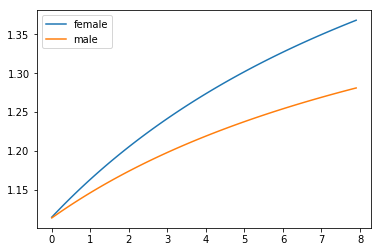

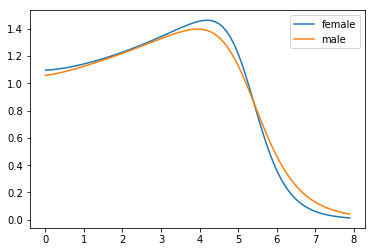

In [277]:
# 分析不同性别的损失厌恶值

def get_trading_dates():
    dict_dt_returns = {}
    dates = list(pd.read_csv('data/VIP_day.csv')['date'])
    returns = list(pd.read_csv('data/VIP_day.csv')['close'])
    for d, r in zip(dates, returns):
        dict_dt_returns[d] = r
        
    return dict_dt_returns
    
    
def get_clas_value(col_name):
    dict_dt_returns = get_trading_dates()
    X = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    m5 = []
    _sum = []
    '''
    获取某类用户的发帖量及情绪，以及当日收益率
    '''
    for line in open('data/results_user_class.txt'):
        dt, data = line.strip().split(' @@ ')
        if dt not in dict_dt_returns:
            continue
        d = json.loads(data)[col_name]
        X.append(dict_dt_returns[dt])
        m1.append(d[0])
        m2.append(d[1])
        m3.append(d[2])
        m4.append(d[3])
        m5.append(d[4])
        _sum.append(d[5])
    
    rs = pd.DataFrame({'close': X, 'm1': m1,
                  'm2': m2, 'm3': m3,
                  'm4': m4, 'm5': m5,
                  'su': _sum,})
    return rs


# 女性
data = get_clas_value('f')
    
x_n = data.close[data.close<0]
y_n = (data.su)[data.close<0]
x = data.close[data.close>0]
y = (data.su)[data.close>0]
r1 = my_analysis(x_n, y_n, x, y, hi='Kay')

# 男性
data = get_clas_value('m')
    
x_n = data.close[data.close<0]
y_n = (data.su)[data.close<0]
x = data.close[data.close>0]
y = (data.su)[data.close>0]
r2 = my_analysis(x_n, y_n, x, y, hi='Kay')

pass
# 粉丝数 不能粒度太细

# looms = []
# for i in range(7):
#     print('---------- 粉丝数 {}^10 ----------'.format(i))
#     data = get_clas_value('fol' + str(i))

#     x_n = data.close[data.close<0]
#     y_n = (data.su)[data.close<0]
#     x = data.close[data.close>0]
#     y = (data.su)[data.close>0]
#     looms.append(scatter_and_line(x_n, y_n, x, y))
# plt.plot(range(7), looms)
# plt.show()

x = np.arange(0, 8, 0.1)
plt.plot(x, r1['y_ratio'], label='female')
plt.plot(x, r2['y_ratio'], label='male')
plt.legend()
plt.show()
plt.close()

plt.plot(x, r1['non_y_ratio'], label='female')
plt.plot(x, r2['non_y_ratio'], label='male')
plt.legend()
plt.show()
plt.close()


# 按粉丝数分成3组用户

分别是0~100, 100~10000, >10000

return > 0
---------- 收益率 < 0 ----------
相关性： -0.40299608959226485
参数： -1161.894281033676 10769.638376363187
R^2： 0.16240584822665693
[[Variables]]
    k: -1161.89428 +/- 219.128365 (18.86%) (init = 1000)
    b:  10769.6385 +/- 617.413659 (5.73%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.220330520488077
参数： 776.3899652801646 9521.04244450561
R^2： 0.048545538258547016
[[Variables]]
    k:  776.389965 +/- 245.511147 (31.62%) (init = -1000)
    b:  9521.04259 +/- 495.326567 (5.20%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.496534387347987
平衡点： 0.6441758654501331


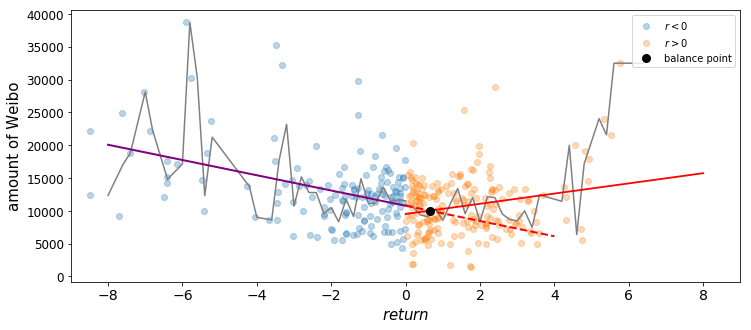

收益率为0： 1.1311406748930224
收益率为1： 1.1586900678326553
收益率为2： 1.1823764636059166
收益率为4： 1.2210106192723087
收益率为6： 1.2511831451506528


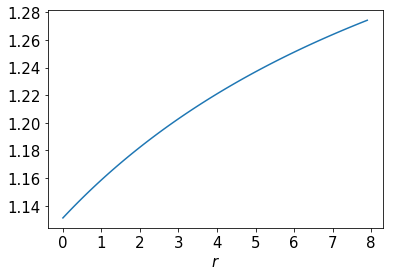

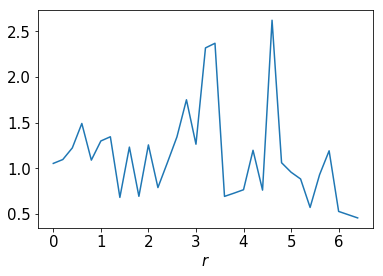

return > 0
[[Variables]]
    A1:  5.3810e-04 +/- 0.00237257 (440.92%) (init = 776.39)
    A2:  10.0013246 +/- 2.57627206 (25.76%) (init = 0.88)
    b:   10367.7439 +/- 298.709409 (2.88%) (init = 9521.042)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.999
    C(A1, b)  = -0.207
    C(A2, b)  =  0.202
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  646.452947 +/- 698.672997 (108.08%) (init = 1161.894)
    A2:  1.29541333 +/- 0.53397327 (41.22%) (init = 1.5)
    b:   11230.7842 +/- 874.509638 (7.79%) (init = 10769.64)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.985
    C(A1, b)  = -0.825
    C(A2, b)  =  0.769


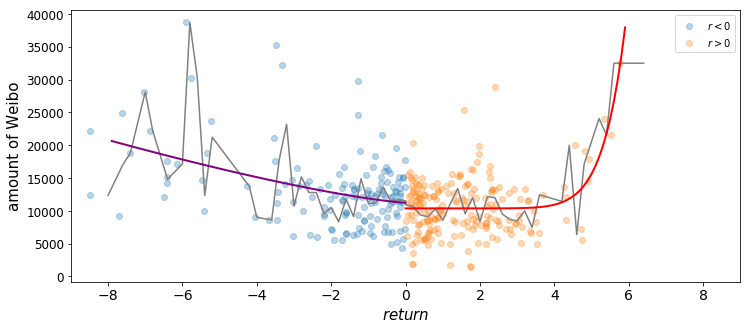

收益率为0.5： 1.10864638061669
收益率为1： 1.145595098577373
收益率为2： 1.2362191750147091
收益率为4： 1.383451236528657
收益率为6： 0.4144978785385328


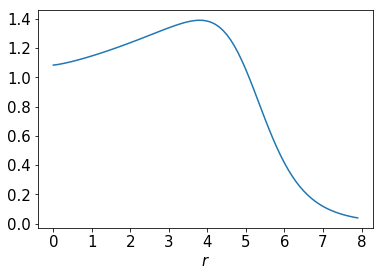

return > 0
---------- 收益率 < 0 ----------
相关性： -0.5018220165715571
参数： -2621.295127882815 19356.475907192777
R^2： 0.2518253363159437
[[Variables]]
    k: -2621.29513 +/- 375.218034 (14.31%) (init = 1000)
    b:  19356.4762 +/- 1057.21020 (5.46%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.2752476122841587
参数： 1615.2681804191673 17484.461153006436
R^2： 0.07576124806813056
[[Variables]]
    k:  1615.26818 +/- 402.981521 (24.95%) (init = -1000)
    b:  17484.4614 +/- 813.028056 (4.65%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.622823478886695
平衡点： 0.44187106811739013


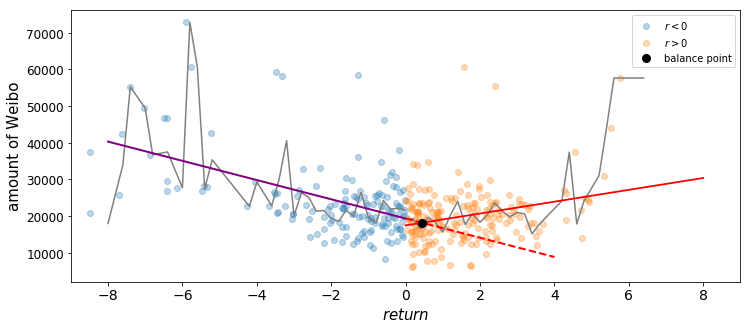

收益率为0： 1.107067340411829
收益率为1： 1.1506849469648375
收益率为2： 1.1875003193467795
收益率为4： 1.2462305737219217
收益率为6： 1.290997792191145


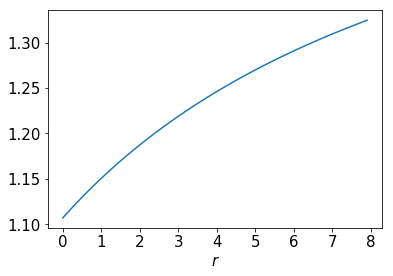

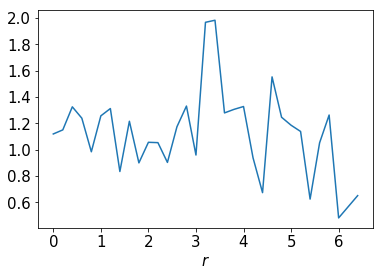

return > 0
[[Variables]]
    A1:  2.6072e-05 +/- 1.4868e-04 (570.28%) (init = 1615.268)
    A2:  12.0460248 +/- 3.29628793 (27.36%) (init = 0.88)
    b:   19472.6765 +/- 496.028756 (2.55%) (init = 17484.46)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.187
    C(A2, b)  =  0.183
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  1322.98147 +/- 1113.94364 (84.20%) (init = 2621.295)
    A2:  1.34592937 +/- 0.41655825 (30.95%) (init = 1.5)
    b:   20521.3781 +/- 1448.15408 (7.06%) (init = 19356.48)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.986
    C(A1, b)  = -0.814
    C(A2, b)  =  0.759


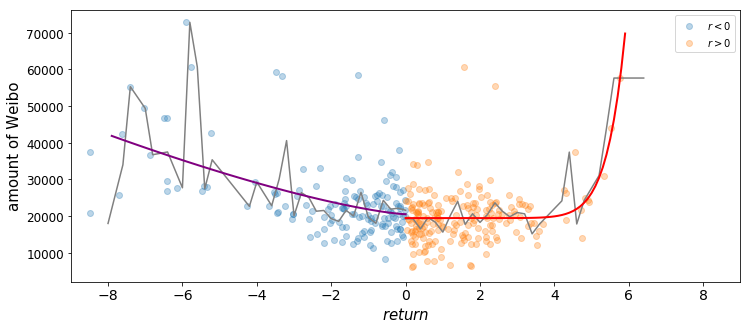

收益率为0.5： 1.0805828170535088
收益率为1： 1.1217954305646747
收益率为2： 1.2265484377868616
收益率为4： 1.4579413217983213
收益率为6： 0.43493042104276347


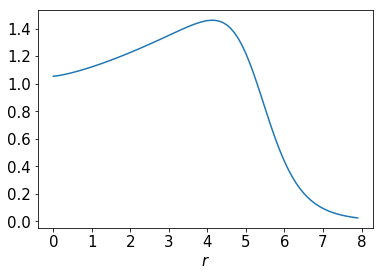

return > 0
---------- 收益率 < 0 ----------
相关性： -0.3114325187169636
参数： -214.38765945564026 3671.2726649609995
R^2： 0.09699021371439176
[[Variables]]
    k: -214.387659 +/- 54.3247899 (25.34%) (init = 1000)
    b:  3671.27272 +/- 153.064926 (4.17%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.698
---------- 收益率 > 0 ----------
相关性： 0.11732459560821895
参数： 114.53367022120258 3332.1157915487493
R^2： 0.013765060734632238
[[Variables]]
    k:  114.533670 +/- 69.2478450 (60.46%) (init = -1000)
    b:  3332.11584 +/- 139.709736 (4.19%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.772
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： -1.871830868962694
平衡点： 1.0311185162283745


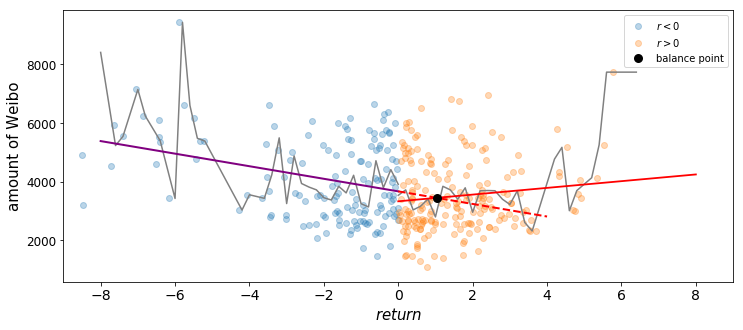

收益率为0： 1.1017842399932363
收益率为1： 1.1273732265251146
收益率为2： 1.1513162429194794
收益率为4： 1.194861219785244
收益率为6： 1.2334428011174123


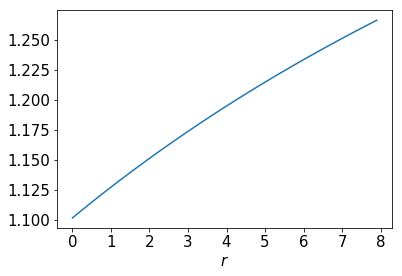

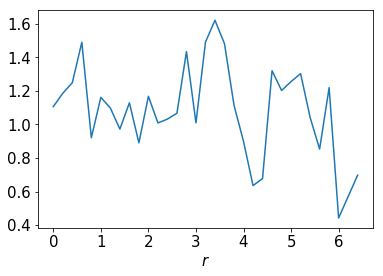

return > 0
[[Variables]]
    A1:  3.0212e-13 +/- 6.7073e-12 (2220.07%) (init = 114.5337)
    A2:  21.2341926 +/- 12.6506578 (59.58%) (init = 0.88)
    b:   3473.05787 +/- 87.6793819 (2.52%) (init = 3332.116)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -1.000
    C(A1, b)  = -0.129
    C(A2, b)  =  0.128
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1:  56.1251348 +/- 98.1997125 (174.97%) (init = 214.3877)
    A2:  1.70062644 +/- 0.87213094 (51.28%) (init = 1.5)
    b:   3812.92824 +/- 175.758135 (4.61%) (init = 3671.273)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.991
    C(A1, b)  = -0.732
    C(A2, b)  =  0.687


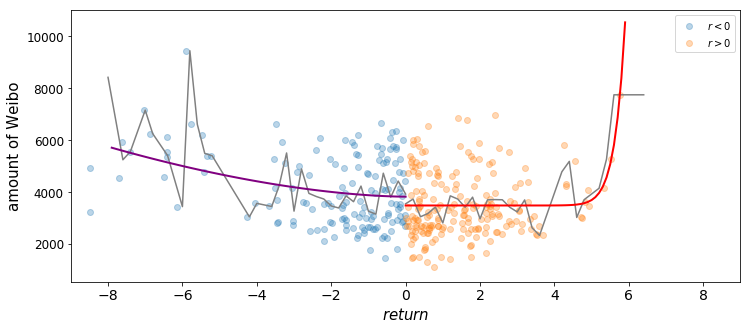

收益率为0.5： 1.102830825103494
收益率为1： 1.1140192644973526
收益率为2： 1.1503863988386038
收益率为4： 1.2679237314375327
收益率为6： 0.3684373147143132


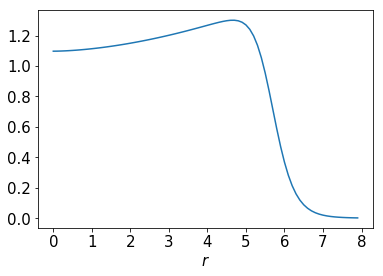

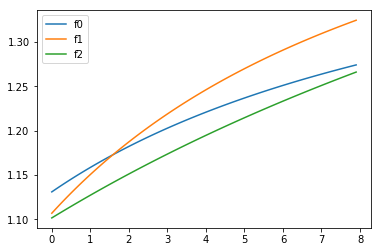

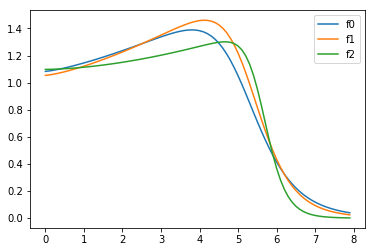

In [278]:
for line in open('data/results_user_class.txt'):
    dt, data = line.strip().split(' @@ ')
    d = json.loads(data)
    new_d = dict(fol0=0, fol1=0, fol2=0)
    for k, v in d.items():
        if k in ['m', 'f']:
            continue
        elif k in ['fol0', 'fol1']:
            new_d['fol0'] += v[5]
        elif k in ['fol2', 'fol3']:
            new_d['fol1'] += v[5]
        else:
            new_d['fol2'] += v[5]
            
#     print(dt, '@@', new_d)

def get_clas_value(col_name):
    dict_dt_returns = get_trading_dates()
    X = []
    _sum = []
    '''
    获取某类用户的发帖量及情绪，以及当日收益率
    '''
    for line in open('data/results_fol_3.txt'):
        dt, data = line.strip().split(' @@ ')
        if dt not in dict_dt_returns:
            continue
        d = json.loads(data)[col_name]
        X.append(dict_dt_returns[dt])
        _sum.append(d)
    
    rs = pd.DataFrame({'close': X, 'su': _sum,})
    return rs



data = get_clas_value('fol0')
x_n = data.close[data.close<0]
y_n = (data.su)[data.close<0]
x = data.close[data.close>0]
y = (data.su)[data.close>0]
r1 = my_analysis(x_n, y_n, x, y, hi='Kay')

data = get_clas_value('fol1')
x_n = data.close[data.close<0]
y_n = (data.su)[data.close<0]
x = data.close[data.close>0]
y = (data.su)[data.close>0]
r2 = my_analysis(x_n, y_n, x, y, hi='Kay')

data = get_clas_value('fol2')
x_n = data.close[data.close<0]
y_n = (data.su)[data.close<0]
x = data.close[data.close>0]
y = (data.su)[data.close>0]
r3 = my_analysis(x_n, y_n, x, y, hi='Kay')

x = np.arange(0, 8, 0.1)
plt.plot(x, r1['y_ratio'], label='f0')
plt.plot(x, r2['y_ratio'], label='f1')
plt.plot(x, r3['y_ratio'], label='f2')
plt.legend()
plt.show()
plt.close()

plt.plot(x, r1['non_y_ratio'], label='f0')
plt.plot(x, r2['non_y_ratio'], label='f1')
plt.plot(x, r3['non_y_ratio'], label='f2')
plt.legend()
plt.show()
plt.close()

(array([-7.58588778e+05, -8.16462155e-05,  7.62100026e+05]), 1)


/Users/kay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in power
  


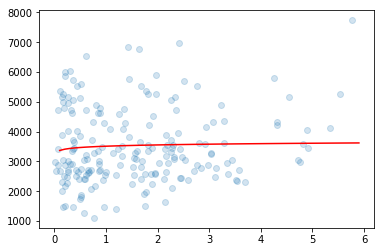

(array([-3.51546962e+06, -5.52067500e-05,  3.51954929e+06]), 1)


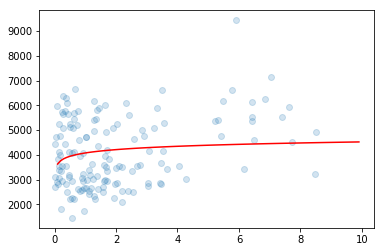

TypeError: union_data() missing 2 required positional arguments: 'y_data' and 'posi'

In [279]:
# 带幂指数


def func(x, p):
    A1, A2, b = p
    return A1 * (x ** A2) + b


def resi(p, y, x): 
    """
    实验数据x, y和拟合函数之间的差，p为拟合需要找到的系数
    """
    return y - func(x, p)

# -----------------------
# 数据不合并
# -----------------------

x_n = data.close[data.close<0]
y_n = data.su[data.close<0]
x = data.close[data.close>0]
y = data.su[data.close>0]


p0 = [1000, 1, 10000] # 拟合参数初始化
plsq = leastsq(resi, p0, args=(y, x))
print(plsq)
plt.scatter(x, y, alpha=0.2)
tmp_x = np.arange(0, 6, 0.1)
plt.plot(tmp_x, func(tmp_x, plsq[0]), 'r')
plt.show()

p0 = [1000, 1, 10000] # 拟合参数初始化
x = [-i for i in x_n]
y = y_n
plsq = leastsq(resi, p0, args=(y, x))
print(plsq)
plt.scatter(x, y, alpha=0.2)
tmp_x = np.arange(0, 10, 0.1)
plt.plot(tmp_x, func(tmp_x, plsq[0]), 'r')
plt.show()

# -----------------------
# 数据分段合并
# -----------------------

x_n = data.close[data.close<0]
y_n = data.su[data.close<0]
x = data.close[data.close>0]
y = data.su[data.close>0]


X, Y = union_data(zip(x, y))
p0 = [1000, 1, 10000] # 拟合参数初始化
plsq = leastsq(resi, p0, args=(Y, X))
print(plsq)
plt.plot(X, Y)
plt.plot(X, func(X, plsq[0]), 'r')
plt.show()


X, Y = union_data(zip(x_n, y_n))
# X取相反数
X = [-x for x in X]
p0 = [1000, 1, 10000] # 拟合参数初始化
plsq = leastsq(resi, p0, args=(Y, X))
print(plsq)
plt.plot(X, Y)
plt.plot(X, func(X, plsq[0]), 'r')
plt.show()


# plsq = leastsq(resi_0, p0, args=(Y_n, X_n))
# print(plsq)

# popt, pcov = optimize.curve_fit(func_0, x_n, y_n, )
# print(popt, pcov)
# plt.plot(x_n, func_0(x_n, *popt), 'g--', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
# plt.show()

将上一个block写成一个函数，封装起来。

## 拟合公式：$y = A_{1} * x^{A_{2}} + A_{3} $

当$return > 0$ 
参数: [6.96e-05, 11, 32100]


当$return < 0$ 
参数: [1810, 1.39, 34400]，注意此时，$x$取相反数


由图可见，当return>0时候，指数为11，异常之大。
而return<0的时候效果较好，为1.39。（之前经典理论指数为0.88）这一差异可能可以解释为，社交网络放大了损失厌恶的现象。

针对return>0的情况，我专门放大看了一下，发现拟合效果实际是不错的。

当return处于0到4范围内，这也可以解释为：当股市为上涨时，在一定范围内，股民反应比较一致（2-3 之间有个异常点），并没有随着收益率增加而显著增加。这也解释了之前的相关性的结果，为啥收益率为正的时候相关性（收益率和微博）总是小于收益率为负时候。

# 使用LMFIT
Non-Linear Least-Squares Minimization and Curve-Fitting for Python


http://lmfit.github.io/lmfit-py/confidence.html#a-basic-example


<!> 下面的结果已经由my_analysis( )收录。

总结：取对数之后效果非常差，因为缺少了常数项去拟合。

下面尝试线性拟合，和之前的线性结果是一致的。

[[Variables]]
    A1:  114.533670 +/- 69.2478464 (60.46%) (init = 1000)
    A2:  3332.11584 +/- 139.709737 (4.19%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) = -0.772


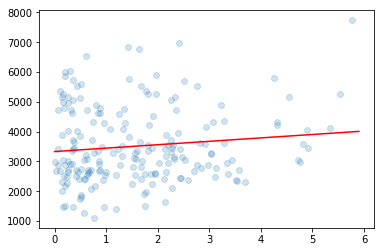

--------------------
[[Variables]]
    A1: -214.387659 +/- 54.3247895 (25.34%) (init = 1000)
    A2:  3671.27272 +/- 153.064926 (4.17%) (init = 10000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, A2) =  0.698


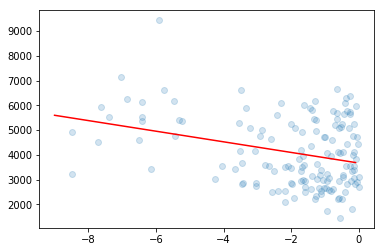

In [15]:
import lmfit

x_n = data.close[data.close<0]
y_n = data.su[data.close<0]
x = data.close[data.close>0]
y = data.su[data.close>0]

# 正
pars = lmfit.Parameters()
pars.add_many(('A1', 1000), ('A2', 10000))

def residual(p):
    return p['A1'] * x + p['A2'] - y

mini = lmfit.Minimizer(residual, pars)
result = mini.minimize()
print(lmfit.fit_report(result.params))
# ci1 = lmfit.conf_interval(mini, result)
# lmfit.printfuncs.report_ci(ci1)

plt.scatter(x, y, alpha=0.2)
x_fit = np.arange(0, 6, 0.1)
y_fit = result.params['A1'].value * x_fit + result.params['A2'].value
plt.plot(x_fit, y_fit, 'r')
plt.show()
plt.close()

print('-' * 20)

# 负
pars = lmfit.Parameters()
pars.add_many(('A1', 1000), ('A2', 10000))

# x_n = [-x for x in x_n]
def residual(p):
    return p['A1'] * x_n + p['A2'] - y_n

mini = lmfit.Minimizer(residual, pars)
result = mini.minimize()
print(lmfit.fit_report(result.params))
# ci2 = lmfit.conf_interval(mini, result)
# lmfit.printfuncs.report_ci(ci2)

plt.scatter(x_n, y_n, alpha=0.2)
x_fit = np.arange(-9, 0, 0.1)
y_fit = result.params['A1'].value * x_fit + result.params['A2'].value
plt.plot(x_fit, y_fit, 'r')
plt.show()
plt.close()


# 数据合并
# X, Y = union_data(zip(x, y))
# p0 = [1000, 10000] # 拟合参数初始化

# def residual(p):
#     return p['A1'] * X + p['A2'] - Y

# mini = lmfit.Minimizer(residual, pars)
# result = mini.minimize()
# print(lmfit.fit_report(result.params))


# X, Y = union_data(zip(x_n, y_n))
# p0 = [1000, 1, 10000] # 拟合参数初始化
# plsq = leastsq(resi, p0, args=(Y, X))
# print(plsq)
# plt.plot(X, Y)
# plt.plot(X, func(X, plsq[0]), 'r')
# plt.show()

线性模型和非线性模型，return > 0 或 < 0，参数满足什么关系？参数的具体含义？

交点，discussion讨论不理性的程度；抛开拟合参数；

## 情绪分类相关
分成有无情绪、然后再分情绪；
文本长度作为特征；
LSTM + CNN模型试一下；
股吧数据，跑一遍word_embedding；
考虑不删停用词；

## 接下来讨论 twitter上面的结果

首先看看sp500的样子～

In [32]:
sp500 = pd.read_csv("data/SP500.csv", index_col="Date")
sp500

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,16.660000,1260000
1950-01-04,16.850000,16.850000,16.850000,16.850000,16.850000,1890000
1950-01-05,16.930000,16.930000,16.930000,16.930000,16.930000,2550000
1950-01-06,16.980000,16.980000,16.980000,16.980000,16.980000,2010000
1950-01-09,17.080000,17.080000,17.080000,17.080000,17.080000,2520000
1950-01-10,17.030001,17.030001,17.030001,17.030001,17.030001,2160000
1950-01-11,17.090000,17.090000,17.090000,17.090000,17.090000,2630000
1950-01-12,16.760000,16.760000,16.760000,16.760000,16.760000,2970000
1950-01-13,16.670000,16.670000,16.670000,16.670000,16.670000,3330000


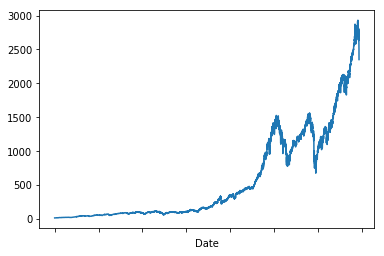

In [33]:
sp500["Close"].plot()

由赵老师提供的twitter数据是2017年1月21日到9月26日

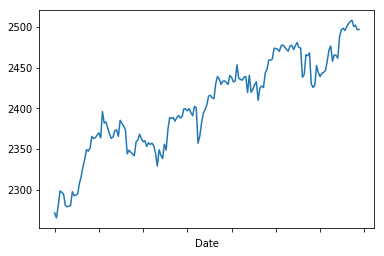

In [34]:
sp = sp500["2017-01-20": "2017-09-26"]
# sp
sp["Close"].plot()

In [40]:
rows = []
init = 1
for date, row in sp.iterrows():
    if init:
        last_close = row["Close"]
        init = None
        continue
    ret = (row["Close"] - last_close) / last_close * 100
    last_close = row["Close"]

    rows.append({
        "Date": date,
        "Return": ret,
        "Volume": row["Volume"]
    })
data = pd.DataFrame(rows)
data

,Date,Return,Volume
0,2017-01-23,-0.269013,3.152710e+09
1,2017-01-24,0.656459,3.810960e+09
2,2017-01-25,0.802609,3.846020e+09
3,2017-01-26,-0.073538,3.610360e+09
4,2017-01-27,-0.086646,3.135890e+09
5,2017-01-30,-0.600954,3.591270e+09
6,2017-01-31,-0.088991,4.087450e+09
7,2017-02-01,0.029836,3.916610e+09
8,2017-02-02,0.057031,3.807710e+09
9,2017-02-03,0.726476,3.597970e+09


In [41]:
data.describe()

,Return,Volume
count,172.000000,1.720000e+02
mean,0.056067,3.442483e+09
std,0.450919,4.792406e+08
min,-1.817821,1.962290e+09
25%,-0.132102,3.159552e+09
50%,0.039281,3.402180e+09
75%,0.234540,3.648962e+09
max,1.367385,5.284720e+09


## 将推特的量进行数据的合并

In [54]:
rows = []

for i, row in data.iterrows():
#     print(i, row["Date"])
    date_str = row["Date"].replace("-", "")
    in_name = "data/stock_tweets/{}_st".format(date_str)
    try:
        tweet_count = len(open(in_name).readlines())
    except FileNotFoundError as e:
        print(e, date_str)
        continue
#     print(i, row["Date"], tweet_count)
    rows.append({
        "date": row["Date"],
        "close": row["Return"],
        "volume": row["Volume"],
        "su": tweet_count
    })
    
data = pd.DataFrame(rows)
data

,close,date,su,volume
0,-0.269013,2017-01-23,3107,3.152710e+09
1,0.656459,2017-01-24,3173,3.810960e+09
2,0.802609,2017-01-25,3338,3.846020e+09
3,-0.073538,2017-01-26,3403,3.610360e+09
4,-0.086646,2017-01-27,2612,3.135890e+09
5,-0.600954,2017-01-30,2517,3.591270e+09
6,-0.088991,2017-01-31,803,4.087450e+09
7,0.575255,2017-02-09,916,3.677940e+09
8,0.604807,2017-02-21,3396,3.579780e+09
9,-0.108220,2017-02-22,3435,3.468670e+09


In [63]:
x_n = data.close[data.close<0]
y_n = data.su[data.close<0]
x = data.close[data.close>0]
y = data.su[data.close>0]

收益率与总量
return > 0
---------- 收益率 < 0 ----------
相关性： 0.02512888960493569
参数： 66.69469757982183 3391.908337183369
R^2： 0.0006314610927772302
[[Variables]]
    k:  66.6947140 +/- 342.535172 (513.59%) (init = 1000)
    b:  3391.90839 +/- 147.336765 (4.34%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) =  0.633
---------- 收益率 > 0 ----------
相关性： 0.17060712722498433
参数： 437.2185355122242 3074.4981767089726
R^2： 0.029106791859962008
[[Variables]]
    k:  437.218540 +/- 287.767514 (65.82%) (init = -1000)
    b:  3074.49822 +/- 131.490981 (4.28%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, b) = -0.719
- - - - - - - - - - 损失厌恶指数 - - - - - - - - - -
斜率比例： 0.15254316128589
平衡点： 0.856652468692997


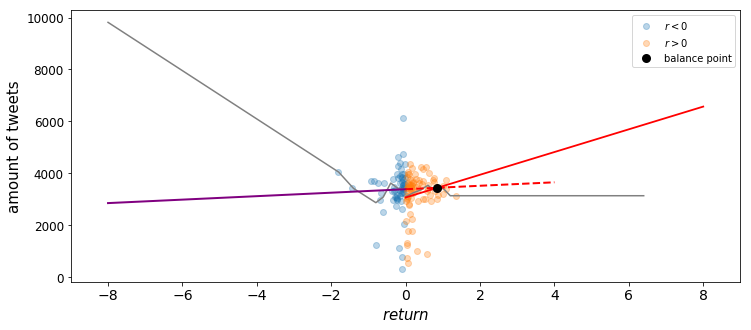

收益率为0： 1.1032396645667102
收益率为1： 0.9468911965567733
收益率为2： 0.8251639334663754
收益率为4： 0.6479138122326985
收益率为6： 0.5250684863325581


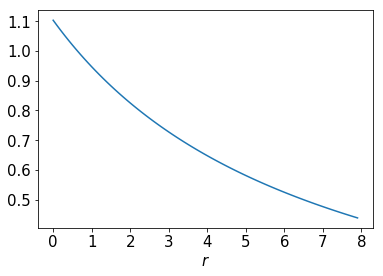

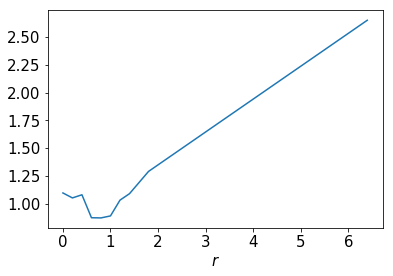

return > 0
[[Variables]]
    A1:  1723345.77 +/- 8.1251e+09 (471472.65%) (init = 1000)
    A2:  1.0774e-04 +/- 0.50617596 (469829.66%) (init = 1)
    b:  -1719814.27 +/- 8.1251e+09 (472440.79%) (init = 4000)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -1.000
    C(A2, b)  =  1.000
    C(A1, A2) = -1.000
- * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - - * - 
return < 0
[[Variables]]
    A1: -417475.496 +/- 2.1890e+09 (524342.21%) (init = -66.6947)
    A2:  2.2832e-04 +/- 1.23114634 (539227.45%) (init = 1.5)
    b:   420672.638 +/- 2.1890e+09 (520357.21%) (init = 3391.908)
[[Correlations]] (unreported correlations are < 0.100)
    C(A1, b)  = -1.000
    C(A2, b)  = -1.000
    C(A1, A2) =  1.000


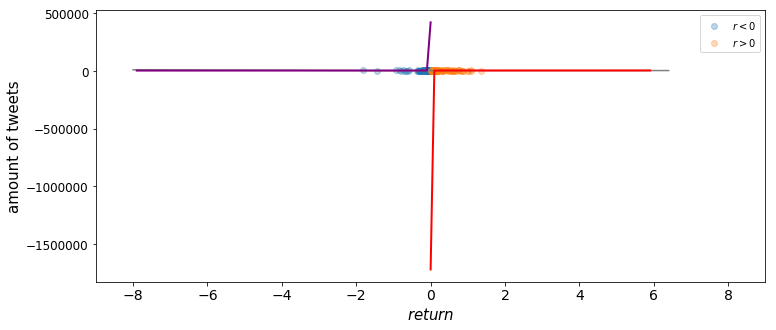

收益率为0.5： 0.9589737970863368
收益率为1： 0.9053215253845636
收益率为2： 0.8554368949956984
收益率为4： 0.8089363549591538
收益率为6： 0.7831691214608355


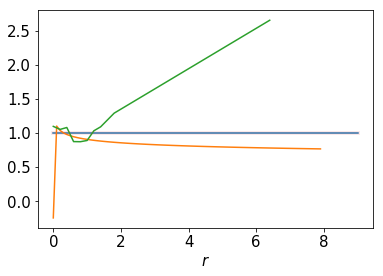

{'hi': 'Kay',
 'k_n': 66.69469757982183,
 'b_n': 3391.908337183369,
 'k': 437.2185355122242,
 'b': 3074.4981767089726,
 'y_ratio': [1.1032396645667102,
  1.0856318138469885,
  1.0685109093766338,
  1.051857026864442,
  1.0356513143781738,
  1.019875921157199,
  1.0045139320216718,
  0.9895493068715574,
  0.9749668248205964,
  0.9607520325561713,
  0.9468911965567733,
  0.9333712588350156,
  0.9201797959063892,
  0.9073049807127646,
  0.8947355472553343,
  0.8824607577147079,
  0.8704703718564616,
  0.8587546185389321,
  0.8473041691566313,
  0.8361101128675914,
  0.8251639334663754,
  0.8144574877766126,
  0.8039829854478373,
  0.7937329700512963,
  0.7837003013783191,
  0.7738781388529392,
  0.7642599259777872,
  0.7548393757389351,
  0.7456104569014196,
  0.736567381132665,
  0.727704590896043,
  0.7190167480613582,
  0.7104987231832118,
  0.7021455854019989,
  0.6939525929257518,
  0.685915184054231,
  0.6780289687095592,
  0.6702897204403588,
  0.6626933688687944,
  0.6552359925521

In [64]:
# 收益率与总量
# 散点图及线性拟合
print("收益率与总量")
x_n = data.close[data.close<0]
y_n = data.su[data.close<0]
x = data.close[data.close>0]
y = data.su[data.close>0]

# scatter_and_line(x_n, y_n, x, y, ylabel='$value(r)$', out='figure/value_r.pdf')
# scatter_and_line(x_n, y_n, x, y)
# non_line(x_n, y_n, x, y)
my_analysis(x_n, y_n, x, y, hi='Kay')